In [33]:
import pandas as pd          
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime    
from pandas import Series 
import seaborn as sns

In [7]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import datetime
import warnings
from lightgbm import LGBMRegressor
from chinese_calendar import is_workday
import joblib
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['font.sans-serif'] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

In [8]:
df  = pd.read_csv("sales_data.csv")
pre = pd.read_csv("predict_sku0.csv")
df.head()

,order_date,order_date.1,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,Year,...,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_workday,is_holiday,sales,year,month
0,2015-09-02,2015-09-02,104,20028,301,405,1,1005.0,11,2015,...,0,0,0,0,0,1,0,11055.0,2015,9
1,2015-09-03,2015-09-03,102,20354,303,401,1,1420.0,64,2015,...,0,0,0,0,0,0,1,90880.0,2015,9
2,2015-09-04,2015-09-04,101,20586,306,407,1,978.0,7,2015,...,0,0,0,0,0,0,1,6846.0,2015,9
3,2015-09-04,2015-09-04,101,20230,306,407,1,864.0,66,2015,...,0,0,0,0,0,0,1,57024.0,2015,9
4,2015-09-04,2015-09-04,105,21619,306,402,0,274.0,102,2015,...,0,0,0,0,0,0,1,27948.0,2015,9


In [9]:
pre.head()

,sales_region_code,item_code,first_cate_code,second_cate_code
0,101,20011,303,401
1,101,20039,305,412
2,101,20113,308,404
3,101,20178,307,403
4,101,20215,302,408


In [181]:
df["order_date"]=df["order_date"].apply(pd.to_datetime,format='%Y-%m-%d')

In [182]:
df = df.drop(["order_date.1"],axis=1)

In [12]:
df.columns

Index(['order_date', 'sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'item_price', 'ord_qty', 'Year',
       'Month', 'day', 'day of the week', 'quarter', 'is_month_start',
       'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start',
       'is_year_end', 'is_workday', 'is_holiday', 'sales', 'year', 'month'],
      dtype='object')

In [13]:
pre.columns

Index(['sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code'],
      dtype='object')

In [14]:
df_2=df[['sales_region_code', 'first_cate_code','second_cate_code','item_code','ord_qty']]
df_2

,sales_region_code,first_cate_code,second_cate_code,item_code,ord_qty
0,104,301,405,20028,11
1,102,303,401,20354,64
2,101,306,407,20586,7
3,101,306,407,20230,66
4,105,306,402,21619,102
...,...,...,...,...,...
58099,103,302,408,20337,2
58100,103,306,402,20146,87
58101,103,306,407,21911,2
58102,102,302,408,21195,134


#检验数据

让我们运行平稳性测试，看看结果：

平稳性意味着时间序列的统计财产不会随时间变化。一些平稳数据是（随时间变化的常数均值、常数方差和常数协方差）。

有两种方法可以测试时间序列的平稳性

A） 滚动平均值：可视化

B） Dicky-Fuller检验：统计检验


A） 滚动平均值：时间序列模型的滚动分析通常用于评估模型随时间的稳定性。窗口每周滚动（在数据中滑动），其中每周取平均值。滚动统计是一种可视化测试，我们可以将原始数据与滚动数据进行比较，并检查数据是否静止。


B） Dicky-Fuller检验：该检验为我们提供了p值等统计数据，以了解我们是否可以拒绝零假设。如果p值小于临界值（比如0.5），我们将拒绝零假设，并说数据是稳定的。

In [15]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #确定滚动状态  
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()
    
    #绘制滚动状态 
    plt.subplots(figsize = (16, 6))
    orginal = plt.plot(timeseries.resample('w').mean(), color='blue',linewidth= 3, label='Orginal')
    roll_mean = plt.plot(roll_mean.resample('w').mean(), color='red',linewidth= 3, label='Rolling Mean')
    roll_mean = plt.plot(roll_std.resample('w').mean(), color='green',linewidth= 3, label='Rolling Std')
    
    plt.legend(loc='best')
    plt.show()
    
    #执行Dickey Fuller测试
    print('Result of Dickey-Fuller test:')
    result= adfuller(timeseries, autolag='AIC')
    
    print('ADF Statestics: %f' %result[0])
    print('P-value: %f' %result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(key, value)

In [16]:
test_df = df[['order_date','ord_qty']].set_index('order_date')
test_df

,ord_qty
order_date,
2015-09-02,11
2015-09-03,64
2015-09-04,7
2015-09-04,66
2015-09-04,102
...,...
2018-12-20,2
2018-12-20,87
2018-12-20,2


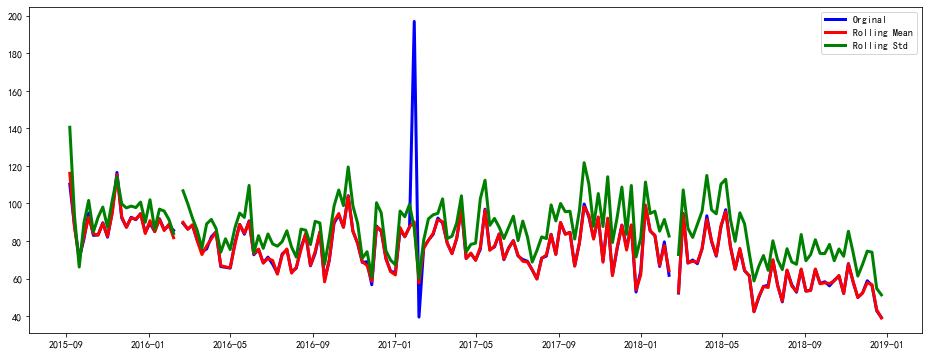

Result of Dickey-Fuller test:
ADF Statestics: -24.833047
P-value: 0.000000
Critical Values:
1% -3.430462660244337
5% -2.861589793666387
10% -2.5667965034953024


In [17]:
test_stationarity(test_df)

从上面的图表中我们可以观察到，数据的平均值和方差并没有随着时间的推移而发生最大的变化。所以，我们不计算任何变换。总的来说就是数据是稳定的，所以也说明了无法用差分的形似来处理，如果**差分**来做反而会使得模型变得**更差--切记**

adfuller函数说明：返回的结果是一个数组。
第一个是adt检验的结果，也就是书上说的t统计量的值。
第二个是t统计量的P值。
第三个是计算过程中用到的延迟阶数。
第四个是用于ADF回归和计算的观测值的个数。
第五个是配合第一个一起看的，是在99%，95%，90%置信区间下的临界的ADF检验的值。如果第一个值比第五个值小，证明平稳

第一个值  -24.833047 比 第五个值三个置信区间的临界ADF检验值都小，所以证明平稳。

In [18]:
#进一步检验，异方差检验

“异方差性”指数据沿回归线均匀分布的情况。基本上，这意味着数据更紧密地组合在一起，因此“尖峰”更少（即有更多的峰/谷）。

异方差数据意味着，与“正态分布”数据集相比，观察峰值和低谷（即异常值）的频率更高。这意味着模型很难预测这些峰值。


为了缓解这种情况，通常需要对异方差数据进行Box-Cox/log转换，以抑制极端峰值/波谷。也就是说，将数据更紧密地结合在一起，以便模型能够更好地拟合整个数据，并达到峰值/低谷。

In [19]:
from statsmodels.stats.diagnostic import het_breuschpagan as BP
import statsmodels.api as sm
from statsmodels.formula.api import ols

bp_data =df.copy()
bp_data['Time_Period'] = range(1, len(bp_data)+1)

formula = 'ord_qty ~ Time_Period'

model = ols(formula, bp_data).fit()

result = BP(model.resid, model.model.exog)

print('ADF Statistic: ', result[0])
print('P-value: {:.20f}'.format(result[1]))

ADF Statistic:  22.534429536907265
P-value: 0.00000206410761217831


得到了上述结果，这意味着：

数据是平稳的（因为P值低于0.05）

数据是异方差的（因为P值不低于0.05）

这些统计测试的结果意味着线性回归的传统假设已经被违反。也就是说，更传统的线性回归、统计F检验和T检验方法变得无效。这也是在第三部分那，用了线性回归不行的原因吧！

因此，该预测模型不会考虑这些测试。

自相关
自相关基本上是指特定时间点与前一个时间点之间的相关性，例如，今天的值与上周的值高度相关。

同样，Python Statsmodel有一个强大的自相关函数（ACF），可以很容易地产生以下结果：

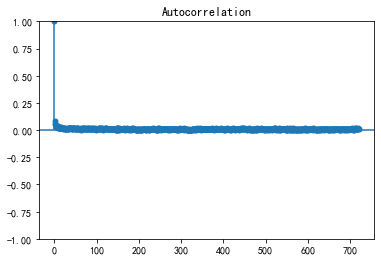

In [20]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(test_df,lags=720)
plt.show()

上图显示的是前一点与当前点的相关性。数字越远离0，相关性就越强。
从上图可以看书，数据之间相关性很弱

E:\anaconda3-2022\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


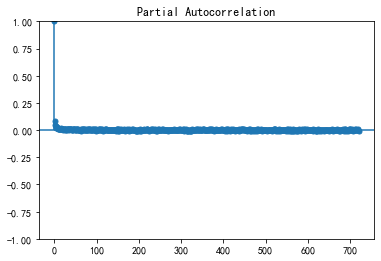

In [21]:
plot_pacf(test_df,lags=720)

plt.show()

这种自相关分析的另一个改进是偏自相关函数（PACF）。
该函数是ACF的一个变体，因为它在去除了之前的滞后中已经解释的影响后，
发现了残差的相关性。这样，就不会产生“复合”相关效应。


这张图表显示，过去20天左右的相关性更强，但越往回走，这种影响就越不明显。

所以在下面的预测时，对于中期，长期预测效果可能并不好

短期预测是可以的

**按天数进行合并后进行检验**

In [22]:
df = df.set_index('order_date')

In [23]:
df.head()

,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,Year,Month,day,...,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_workday,is_holiday,sales,year,month
order_date,,,,,,,,,,,,,,,,,,,,,
2015-09-02,104,20028,301,405,1,1005.0,11,2015,9,2,...,0,0,0,0,0,1,0,11055.0,2015,9
2015-09-03,102,20354,303,401,1,1420.0,64,2015,9,3,...,0,0,0,0,0,0,1,90880.0,2015,9
2015-09-04,101,20586,306,407,1,978.0,7,2015,9,4,...,0,0,0,0,0,0,1,6846.0,2015,9
2015-09-04,101,20230,306,407,1,864.0,66,2015,9,4,...,0,0,0,0,0,0,1,57024.0,2015,9
2015-09-04,105,21619,306,402,0,274.0,102,2015,9,4,...,0,0,0,0,0,0,1,27948.0,2015,9


In [24]:
daily_data = df.resample(rule='D').sum()
daily_data = daily_data.asfreq('D')
daily_data.head(10)

,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,Year,Month,day,...,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_workday,is_holiday,sales,year,month
order_date,,,,,,,,,,,,,,,,,,,,,
2015-09-02,104,20028,301,405,1,1005.0,11,2015,9,2,...,0,0,0,0,0,1,0,11055.0,2015,9
2015-09-03,102,20354,303,401,1,1420.0,64,2015,9,3,...,0,0,0,0,0,0,1,90880.0,2015,9
2015-09-04,1022,210247,3051,4072,9,5830.0,1481,20150,90,40,...,0,0,0,0,0,0,10,854333.0,20150,90
2015-09-05,1330,273657,3964,5280,11,12106.0,2366,26195,117,65,...,0,0,0,0,0,0,13,1940394.0,26195,117
2015-09-06,3265,668209,9750,13007,30,32251.0,2363,64480,288,192,...,0,0,0,0,0,32,0,1726826.0,64480,288
2015-09-07,2561,526368,7627,10164,22,22661.0,2735,50375,225,175,...,0,0,0,0,0,25,0,1655344.0,50375,225
2015-09-08,2047,419959,6096,8117,16,17125.0,1625,40300,180,160,...,0,0,0,0,0,20,0,1214165.0,40300,180
2015-09-09,3793,772089,11288,15043,30,28523.0,4364,74555,333,333,...,0,0,0,0,0,37,0,2779880.0,74555,333
2015-09-10,3169,656516,9452,12631,29,24305.0,2321,62465,279,310,...,0,0,0,0,0,31,0,1747704.0,62465,279


In [25]:
daily_data.index

DatetimeIndex(['2015-09-02', '2015-09-03', '2015-09-04', '2015-09-05',
               '2015-09-06', '2015-09-07', '2015-09-08', '2015-09-09',
               '2015-09-10', '2015-09-11',
               ...
               '2018-12-11', '2018-12-12', '2018-12-13', '2018-12-14',
               '2018-12-15', '2018-12-16', '2018-12-17', '2018-12-18',
               '2018-12-19', '2018-12-20'],
              dtype='datetime64[ns]', name='order_date', length=1206, freq='D')

In [26]:
D_data=daily_data[["ord_qty"]]
D_data.head()

,ord_qty
order_date,
2015-09-02,11
2015-09-03,64
2015-09-04,1481
2015-09-05,2366
2015-09-06,2363


In [27]:
D_data.to_csv('D_data.csv')

# 季节分解

从高层次上讲，时间序列数据可以看作是组合在一起的组件。也就是说： 数据=水平+趋势+季节性+噪音

级别：系列中的平均值。

趋势：系列中的增加或减少值。

季节性：系列中重复的短期周期。

噪声/残余：序列中的随机变化。

使用Python statsmodel库，可以“分解”上述组件（即季节分解）：

<Figure size 1440x864 with 0 Axes>

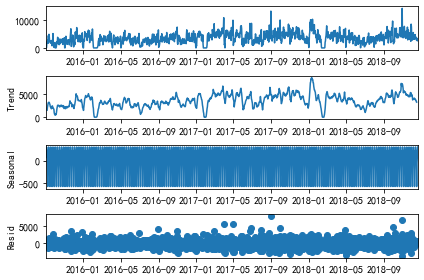

In [28]:
#长期趋势Trend、季节性seasonality和随机残差residuals。
decomposition = seasonal_decompose(D_data, model='additive')
fig = plt.figure(figsize =(20,12))
fig = decomposition.plot()
plt.show()

现在跳出的一件事是很难看到发生了什么，因为图表是非常“打包在一起”的。

更“传统”的经济计量/统计模型，如Holtwiners和SARIMA，需要3个特征才能正常工作，即：

季节性：数据集本质上是周期性的

平稳性：数据集的属性不会随时间而改变

自相关：当前和过去（即“滞后”）数据点之间存在相似性

我们把噪音降低到每周的水平怎么样


In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
weekly_data = df.resample(rule='W').sum()

In [30]:
weekly_data= weekly_data[["ord_qty"]]

In [31]:
weekly_data

,ord_qty
order_date,
2015-09-06,6285
2015-09-13,22346
2015-09-20,14882
2015-09-27,13613
2015-10-04,3323
...,...
2018-11-25,30901
2018-12-02,36109
2018-12-09,27205


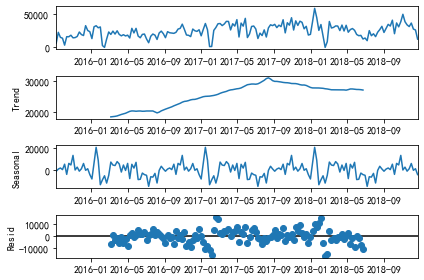

In [32]:
#长期趋势Trend、季节性seasonality和随机残差residuals。
decomposition = seasonal_decompose(weekly_data, model='additive')

fig = decomposition.plot()
plt.show()

此外，你可以看到，在过去几年里，数据的趋势变化不大，并且具有一定的规律性，每年的一月份左右会达到峰值

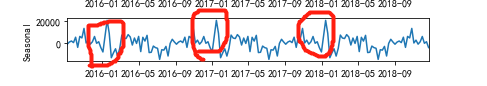


请注意，2015年这不是一个完整的一年，将扭曲热图。

首先，让我们构造dataframe表。

In [33]:
daily_data.index.day_name()

Index(['Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       ...
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday', 'Tuesday', 'Wednesday', 'Thursday'],
      dtype='object', name='order_date', length=1206)

In [34]:
#为热图创建新数据集
heatmap_data = daily_data.copy()
#首先，我们需要将工作日添加为列
heatmap_data['Weekday_Name'] = daily_data.index.day_name()

#接下来，我们将年份添加为列，并将数据分组到年度星期一级别
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Weekday_Name']).sum()

#重置索引
heatmap_data = heatmap_data.reset_index()

# 我们放弃2015年，因为这不是一整年
heatmap_data = heatmap_data[heatmap_data['Year'] != 2015]

#将其转换为热图的统一数据格式 
heatmap_data = heatmap_data.pivot(index='Year', columns='Weekday_Name', values='ord_qty')

heatmap_data = heatmap_data[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

heatmap_data.head(5)

Weekday_Name,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Year,,,,,,,
2016,128096,145257,159919,167563,161053,160313,146240
2017,189722,206070,209570,235126,229211,225989,211883
2018,163324,211706,211878,210805,207831,206207,174855


Text(0.5, 1.0, 'Heatmap - by day of year')

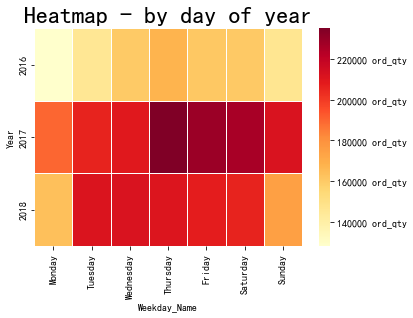

In [35]:
#通过热图可视化
import seaborn as sns
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f ord_qty'}).set_title('Heatmap - by day of year',fontsize = 24)

In [36]:
heatmap_data = daily_data.copy()

heatmap_data['Month'] = daily_data.index.month_name()
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Month']).sum()
heatmap_data = heatmap_data.reset_index()
heatmap_data = heatmap_data[heatmap_data['Year'] != 2015]
heatmap_data = heatmap_data.pivot(index='Year', columns='Month', values='ord_qty')
heatmap_data = heatmap_data[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']]
heatmap_data.head(10)

Month,January,February,March,April,May,June,July,August,September,October,November,December
Year,,,,,,,,,,,,
2016,128073,41265,100257,74516,99082,73807,63130,88411,84573,125601,80358,109368
2017,90491,103877,162077,138628,134634,113103,87276,128490,140585,150067,146830,111513
2018,182378,61341,140100,123763,110166,65477,78925,108812,137529,154485,151031,72599


Text(0.5, 1.0, 'Heatmap - by Month of year')

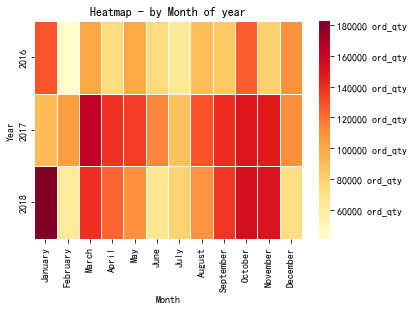

In [37]:
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f ord_qty'}).set_title('Heatmap - by Month of year')


In [38]:
##############################################################################

# 预测3个月需求量--按天--单纯按照日期进行预测

我们的目的是预测每个商品在未来3个月销售额，属于时间序列预测类型；
那首先我们先用简单的时间序列预测类型练练手，例如就预测下个月所有商品销售量。

In [ ]:
D_data=daily_data["ord_qty"]

In [40]:
D_data.head()

,ord_qty
order_date,
2015-09-02,11
2015-09-03,64
2015-09-04,1481
2015-09-05,2366
2015-09-06,2363


In [41]:
#我们的目标是3个月的预测（即预测数据集中的最后)
cutoff = '2018-06-21'

D_data.sort_index()

train = D_data[:cutoff]
test = D_data[cutoff:]
print(train.shape,test.shape)

(1024, 1) (183, 1)


In [42]:
baseline_prediction = train['2017-12-20':'2018-06-20']

baseline_prediction.index = pd.date_range(start='2018-06-21', end='2018-12-20', freq='D')

print(baseline_prediction.shape)
baseline_prediction.tail()

(183, 1)


,ord_qty
2018-12-16,1620
2018-12-17,1981
2018-12-18,53
2018-12-19,1432
2018-12-20,2613


可以看出单纯的预测并不准确

In [43]:
def engineer_date_attributes(df):
    #从前一部分的分析中可以得出，在日期中，主要是还是看这三个量
    df['DOW'] = df.index.dayofweek
    df['Month'] = df.index.month
    df['WOY'] = df.index.weekofyear
    df = df.reset_index()

    df = df.set_index(['Month', 'DOW', 'WOY'])

    return df

#然后在一周中的每一天得到曲线的“形状”
#也就是说，它代表的是月份的百分比
current_df = D_data
current_df = engineer_date_attributes(current_df)
current_df['SHAPE_AVG'] = current_df.reset_index().groupby(by=['Month', 'DOW']).mean()['ord_qty']
current_df['ord_SHAPE_AVG'] = current_df['ord_qty'] / current_df['SHAPE_AVG']
current_df = current_df.reset_index().groupby(by=['Month', 'DOW', 'WOY']).mean()

current_df.head(40)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_15648\666768046.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DOW'] = df.index.dayofweek
C:\Users\lenovo\AppData\Local\Temp\ipykernel_15648\666768046.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df.index.month
C:\Users\lenovo\AppData\Local\Temp\ipykernel_15648\666768046.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the 

ord_qty    SHAPE_AVG  ord_SHAPE_AVG
Month DOW WOY                                         
1     0   1    1121.333333  3725.071429       0.301023
          2    6070.333333  3725.071429       1.629588
          3    5536.333333  3725.071429       1.486235
          4    3044.333333  3725.071429       0.817255
          5    2417.000000  3725.071429       0.648847
      1   1    3449.333333  3924.214286       0.878987
          2    5094.666667  3924.214286       1.298264
          3    4839.000000  3924.214286       1.233113
          4    2770.000000  3924.214286       0.705874
          5    3240.000000  3924.214286       0.825643
      2   1    4197.000000  4249.076923       0.987744
          2    4545.666667  4249.076923       1.069801
          3    4816.666667  4249.076923       1.133580
          4    2975.333333  4249.076923       0.700231
          5    5634.000000  4249.076923       1.325935
      3   1    4556.000000  4587.083333       0.993224
          2    6741.000000  4587.083333       1.469561
          3    3718.333333  4587.083333       0.810610
          4    3333.000000  4587.083333       0.726606
      4   1    6463.666667  4651.153846       1.389691
          2    6247.333333  4651.153846       1.343179
          3    5442.000000  4651.153846       1.170032
          4    2002.000000  4651.153846       0.430431
          53      0.000000  4651.153846       0.000000
      5   1    5261.666667  4467.461538       1.177775
          2    6465.666667  4467.461538       1.447280
          3    3863.000000  4467.461538       0.864697
          4    2821.666667  4467.461538       0.631604
          53   2841.000000  4467.461538       0.635932
      6   1    6739.333333  4644.785714       1.450946
          2    6688.333333  4644.785714       1.439966
          3    4919.666667  4644.785714       1.059181
          4    1962.666667  4644.785714       0.422553
          52    975.000000  4644.785714       0.209913
          53   3122.000000  4644.785714       0.672152
2     0   5    2411.000000  2196.769231       1.097521
          6    2183.666667  2196.769231       0.994036
          7    1256.333333  2196.769231       0.571900
          8    1326.666667  2196.769231       0.603917
          9    3949.000000  2196.769231       1.797640

In [44]:
future_df = pd.DataFrame()
future_df['Datetime'] = pd.date_range(start='2018-06-20', end='2019-03-21', freq='D')
future_df = future_df.set_index('Datetime')
future_df = engineer_date_attributes(future_df)

#使用DOW，Month WOY将数据转发到预测范围，应用当前年份的形状
baseline_v2_prediction = future_df.merge(current_df[['SHAPE_AVG', 'ord_SHAPE_AVG']], how='left', left_on=['Month', 'DOW', 'WOY'], right_on=['Month', 'DOW', 'WOY'])
baseline_v2_prediction['ord_qty'] = baseline_v2_prediction['ord_SHAPE_AVG'] * baseline_v2_prediction['SHAPE_AVG']

baseline_v2_prediction = baseline_v2_prediction.set_index('Datetime').drop(columns=['SHAPE_AVG', 'ord_SHAPE_AVG'])

baseline_v2_prediction.head(20)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_15648\666768046.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['WOY'] = df.index.weekofyear


,ord_qty
Datetime,
2018-06-20,3075.333333
2018-06-21,3204.333333
2018-06-22,3024.666667
2018-06-23,4842.333333
2018-06-24,3266.333333
2018-06-25,2080.000000
2018-06-26,3294.333333
2018-06-27,3687.666667
2018-06-28,4401.666667


In [45]:
baseline_v2_prediction.tail()

,ord_qty
Datetime,
2019-03-17,3556.666667
2019-03-18,3863.666667
2019-03-19,3709.666667
2019-03-20,4539.333333
2019-03-21,4669.333333


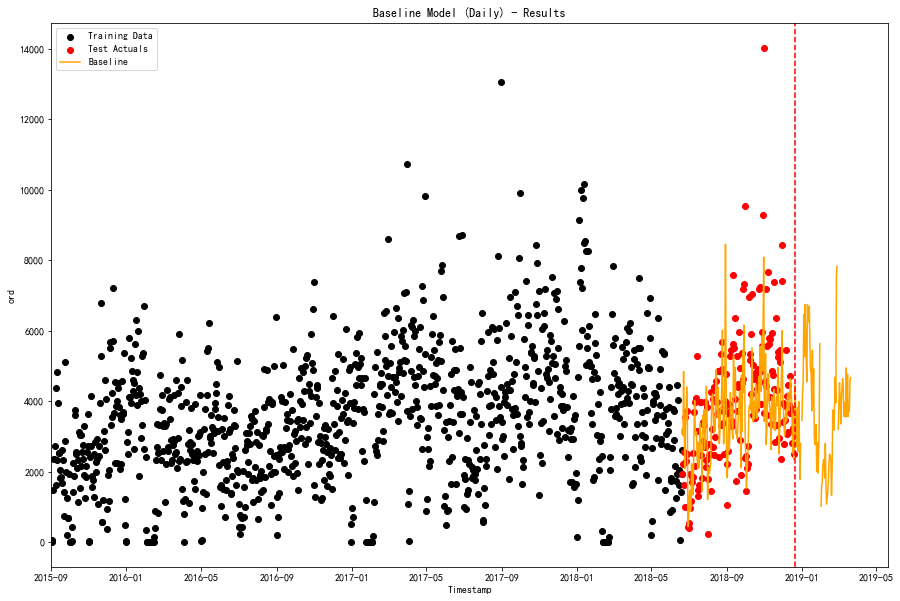

In [46]:
plt.figure(figsize = (15,10))
plt.scatter(x=train.index, y=train['ord_qty'], label='Training Data', color='black')
plt.scatter(x=test.index, y=test['ord_qty'], label='Test Actuals', color='red')
plt.plot(baseline_v2_prediction, label='Baseline', color='orange',)


plt.xlabel("Timestamp")
plt.ylabel("ord")
plt.legend(loc='best')
plt.title('Baseline Model (Daily) - Results')

plt.xlim(datetime(2015, 9, 1),datetime(2019,5 , 21))
import datetime as dt
plt.axvline(dt.datetime(2018, 12, 21), color='red', linestyle='--')
plt.show()

In [47]:
future_df = pd.DataFrame()
future_df['Datetime'] = pd.date_range(start='2018-12-20', end='2019-03-31', freq='D')
future_df = future_df.set_index('Datetime')
future_df = engineer_date_attributes(future_df)

#使用DOW，Month WOY将数据转发到预测范围，应用当前年份的形状
baseline_v2_prediction = future_df.merge(current_df[['SHAPE_AVG', 'ord_SHAPE_AVG']], how='left', left_on=['Month', 'DOW', 'WOY'], right_on=['Month', 'DOW', 'WOY'])
baseline_v2_prediction['ord_qty'] = baseline_v2_prediction['ord_SHAPE_AVG'] * baseline_v2_prediction['SHAPE_AVG']

baseline_v2_prediction = baseline_v2_prediction.set_index('Datetime').drop(columns=['SHAPE_AVG', 'ord_SHAPE_AVG'])

baseline_v2_prediction.head(20)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_15648\666768046.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['WOY'] = df.index.weekofyear


,ord_qty
Datetime,
2018-12-20,3575.000000
2018-12-21,4448.666667
2018-12-22,3723.333333
2018-12-23,3000.666667
2018-12-24,2703.666667
2018-12-25,3809.666667
2018-12-26,2570.333333
2018-12-27,3983.666667
2018-12-28,2898.333333


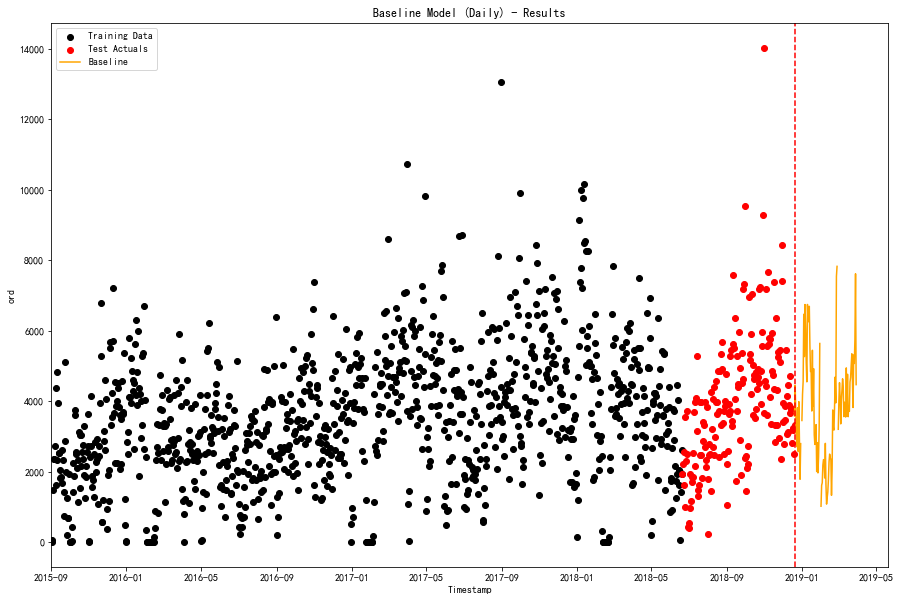

In [48]:
plt.figure(figsize = (15,10))
plt.scatter(x=train.index, y=train['ord_qty'], label='Training Data', color='black')
plt.scatter(x=test.index, y=test['ord_qty'], label='Test Actuals', color='red')
plt.plot(baseline_v2_prediction, label='Baseline', color='orange',)


plt.xlabel("Timestamp")
plt.ylabel("ord")
plt.legend(loc='best')
plt.title('Baseline Model (Daily) - Results')

plt.xlim(datetime(2015, 9, 1),datetime(2019,5 , 21))
import datetime as dt
plt.axvline(dt.datetime(2018, 12, 21), color='red', linestyle='--')
plt.show()

In [49]:
#保存数据
baseline_v2_prediction.to_csv("baseline_D_prediction_data.csv")

In [50]:
baseline_v2_prediction.tail()

,ord_qty
Datetime,
2019-03-27,5067.000000
2019-03-28,5740.666667
2019-03-29,7611.000000
2019-03-30,4467.000000
2019-03-31,NaN


很快你就会发现这是一个相当不错的预测！

但当然，我们需要查看误差/残差，以确定是否：

它是正态分布的（即它不偏向于预测不足或预测过高）

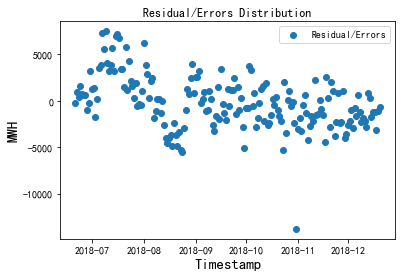

In [51]:
naive_errors = test.copy()
naive_errors['pre_ord_qty'] = baseline_prediction['ord_qty']
naive_errors['error'] = naive_errors['pre_ord_qty'] - naive_errors['ord_qty']

plt.scatter(naive_errors.index, naive_errors['error'], label='Residual/Errors')

plt.title('Residual/Errors Distribution')
plt.xlabel("Timestamp",fontsize = 15)
plt.ylabel("MWH",fontsize = 15)
plt.legend(loc='best')

plt.show()

E:\anaconda3-2022\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Naive 10-day Persistence - Residual/Errors Distribution')

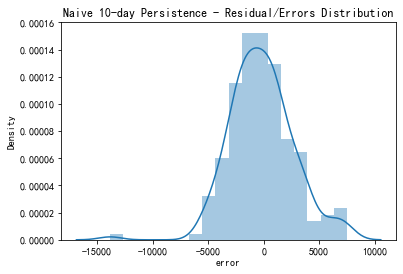

In [52]:
sns.distplot(naive_errors['error'], kde=True);

plt.title('Naive 10-day Persistence - Residual/Errors Distribution')

总体来说预测不错

# 周预测-3个月

In [53]:
W_data = weekly_data

In [54]:
#我们的目标是3个月的预测（即预测数据集中的最后)
cutoff = '2018-06-21'

W_data.sort_index()

train = W_data[:cutoff]
test = W_data[cutoff:]
print(train.shape,test.shape)

(146, 1) (27, 1)


In [55]:
baseline_prediction = train['2017-12-20':'2018-06-20']

baseline_prediction.index = pd.date_range(start='2018-06-21', end='2018-12-20', freq='W')

print(baseline_prediction.shape)
baseline_prediction.tail()

(26, 1)


,ord_qty
2018-11-18,27967
2018-11-25,25336
2018-12-02,19169
2018-12-09,17348
2018-12-16,17814


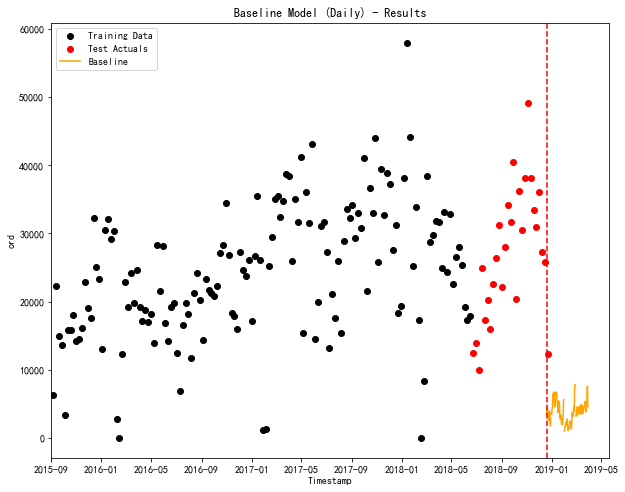

In [56]:
baseline_v2_prediction.tail()
plt.figure(figsize = (10,8))
plt.scatter(x=train.index, y=train['ord_qty'], label='Training Data', color='black')
plt.scatter(x=test.index, y=test['ord_qty'], label='Test Actuals', color='red')
plt.plot(baseline_v2_prediction, label='Baseline', color='orange',)


plt.xlabel("Timestamp")
plt.ylabel("ord")
plt.legend(loc='best')
plt.title('Baseline Model (Daily) - Results')

plt.xlim(datetime(2015, 9, 1),datetime(2019,5 , 21))
import datetime as dt
plt.axvline(dt.datetime(2018, 12, 21), color='red', linestyle='--')
plt.show()

In [57]:
#保存数据
baseline_v2_prediction.to_csv("baseline_W_prediction_data.csv")

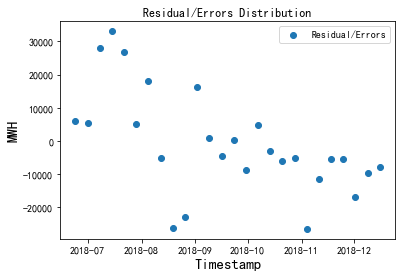

In [58]:
naive_errors = test.copy()
naive_errors['pre_ord_qty'] = baseline_prediction['ord_qty']
naive_errors['error'] = naive_errors['pre_ord_qty'] - naive_errors['ord_qty']

plt.scatter(naive_errors.index, naive_errors['error'], label='Residual/Errors')

plt.title('Residual/Errors Distribution')
plt.xlabel("Timestamp",fontsize = 15)
plt.ylabel("MWH",fontsize = 15)
plt.legend(loc='best')

plt.show()

E:\anaconda3-2022\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Naive 10-day Persistence - Residual/Errors Distribution')

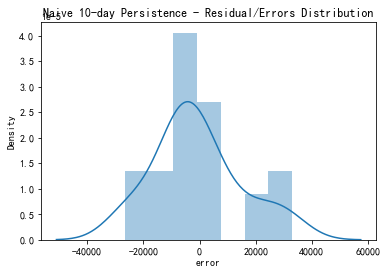

In [59]:
sns.distplot(naive_errors['error'], kde=True);

plt.title('Naive 10-day Persistence - Residual/Errors Distribution')

效果也还行，比起按天预测，误差变大，主要是其样本减少了

# 按月预测-略过

In [60]:
##数据太少没发预测

In [61]:
M_data = df.resample(rule='M').sum()

M_data = daily_data.asfreq('M')

M_data.head()

,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,Year,Month,day,...,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_workday,is_holiday,sales,year,month
order_date,,,,,,,,,,,,,,,,,,,,,
2015-09-30,1848,379897,5462,7298,13,16351.0,1920,36270,162,540,...,18,0,18,0,0,18,0,1350378.0,36270,162
2015-10-31,5334,1095669,15829,21113,42,60199.0,3639,104780,520,1612,...,52,0,0,0,0,0,52,2950009.0,104780,520
2015-11-30,1252,250686,3670,4868,8,9671.0,367,24180,132,360,...,12,0,0,0,0,12,0,240255.0,24180,132
2015-12-31,208,41667,608,808,0,1096.0,26,4030,24,62,...,2,0,2,0,2,2,0,17304.0,4030,24
2016-01-31,4486,925003,13387,17925,39,40430.4,4036,88704,44,1364,...,44,0,0,0,0,0,44,3072551.8,88704,44


In [62]:
M_data.shape

(39, 23)

总体而言

#我们根据单变量的分类预测是可以发现他的效果是很好的
#接下来我们根据单变量进行延伸，进行多级别的分类预测

# 下面部分去看文件B_预测（LGB）---也是借鉴别人的，这里下面出现点问题，直接去看B_预测（LGB）文件

B_预测（LGB）这个文件尽量不运行，防止运行出错，连结果都没了

# 按题目要求进行分类预测

## 整理数据

In [550]:
pd.options.display.max_columns=100 
df  = pd.read_csv("sales_data.csv")

In [551]:
df["order_date"]=df["order_date"].apply(pd.to_datetime,format='%Y-%m-%d')
df = df.drop(["order_date.1"],axis=1)
df.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,Year,Month,day,day of the week,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_workday,is_holiday,sales,year,month
0,2015-09-02,104,20028,301,405,1,1005.0,11,2015,9,2,2,3,0,0,0,0,0,0,1,0,11055.0,2015,9
1,2015-09-03,102,20354,303,401,1,1420.0,64,2015,9,3,3,3,0,0,0,0,0,0,0,1,90880.0,2015,9
2,2015-09-04,101,20586,306,407,1,978.0,7,2015,9,4,4,3,0,0,0,0,0,0,0,1,6846.0,2015,9
3,2015-09-04,101,20230,306,407,1,864.0,66,2015,9,4,4,3,0,0,0,0,0,0,0,1,57024.0,2015,9
4,2015-09-04,105,21619,306,402,0,274.0,102,2015,9,4,4,3,0,0,0,0,0,0,0,1,27948.0,2015,9


In [552]:
df = df.drop(["sales","year","month"],axis=1)

## 构造特征
促销日

In [553]:
#自定义促销日期： 促销日有很多，我们随便选10个代表性的促销日期进行数据统计
list_cux = ['1-1','4-1','2-14','3-1','3-8','4-11','5-1','6-1','6-18','11-11','12-12']
cuxs=[]
#再得到日期是否是自己自定义的促销日：
for index ,row in df.iterrows():
    str_date = str(row['Month'])+'-'+str(row['day'])
    if str_date in list_cux:
#         print(str_date)
        cuxs.append(1)
    else:
        cuxs.append(0)


df['是否促销日']=cuxs
df

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,Year,Month,day,day of the week,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_workday,is_holiday,是否促销日
0,2015-09-02,104,20028,301,405,1,1005.0,11,2015,9,2,2,3,0,0,0,0,0,0,1,0,0
1,2015-09-03,102,20354,303,401,1,1420.0,64,2015,9,3,3,3,0,0,0,0,0,0,0,1,0
2,2015-09-04,101,20586,306,407,1,978.0,7,2015,9,4,4,3,0,0,0,0,0,0,0,1,0
3,2015-09-04,101,20230,306,407,1,864.0,66,2015,9,4,4,3,0,0,0,0,0,0,0,1,0
4,2015-09-04,105,21619,306,402,0,274.0,102,2015,9,4,4,3,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58099,2018-12-20,103,20337,302,408,1,799.0,2,2018,12,20,3,4,0,0,0,0,0,0,1,0,0
58100,2018-12-20,103,20146,306,402,1,327.0,87,2018,12,20,3,4,0,0,0,0,0,0,1,0,0
58101,2018-12-20,103,21911,306,407,1,1006.0,2,2018,12,20,3,4,0,0,0,0,0,0,1,0,0
58102,2018-12-20,102,21195,302,408,1,1855.0,134,2018,12,20,3,4,0,0,0,0,0,0,1,0,0


In [554]:
df.columns

Index(['order_date', 'sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'item_price', 'ord_qty', 'Year',
       'Month', 'day', 'day of the week', 'quarter', 'is_month_start',
       'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start',
       'is_year_end', 'is_workday', 'is_holiday', '是否促销日'],
      dtype='object')

In [555]:
df = df[['order_date', 'sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'item_price', 'ord_qty', 'Year',
       'Month', 'day','is_holiday', '是否促销日','day of the week','is_workday']]
df

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,Year,Month,day,is_holiday,是否促销日,day of the week,is_workday
0,2015-09-02,104,20028,301,405,1,1005.0,11,2015,9,2,0,0,2,1
1,2015-09-03,102,20354,303,401,1,1420.0,64,2015,9,3,1,0,3,0
2,2015-09-04,101,20586,306,407,1,978.0,7,2015,9,4,1,0,4,0
3,2015-09-04,101,20230,306,407,1,864.0,66,2015,9,4,1,0,4,0
4,2015-09-04,105,21619,306,402,0,274.0,102,2015,9,4,1,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58099,2018-12-20,103,20337,302,408,1,799.0,2,2018,12,20,0,0,3,1
58100,2018-12-20,103,20146,306,402,1,327.0,87,2018,12,20,0,0,3,1
58101,2018-12-20,103,21911,306,407,1,1006.0,2,2018,12,20,0,0,3,1
58102,2018-12-20,102,21195,302,408,1,1855.0,134,2018,12,20,0,0,3,1


构造一个多少天的列-命名为D

In [556]:
dt1 = pd.date_range(start="20150902", end="20190131", freq="D")
dt1
dicts = {}
i =1
for date in dt1:
    dicts[str(date).split(' ')[0]]=i
    i+=1
dicts
Ds=[]
for dat in df['order_date']:
    Ds.append(dicts[str(dat).split(' ')[0]])
df['D'] = Ds
df

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,Year,Month,day,is_holiday,是否促销日,day of the week,is_workday,D
0,2015-09-02,104,20028,301,405,1,1005.0,11,2015,9,2,0,0,2,1,1
1,2015-09-03,102,20354,303,401,1,1420.0,64,2015,9,3,1,0,3,0,2
2,2015-09-04,101,20586,306,407,1,978.0,7,2015,9,4,1,0,4,0,3
3,2015-09-04,101,20230,306,407,1,864.0,66,2015,9,4,1,0,4,0,3
4,2015-09-04,105,21619,306,402,0,274.0,102,2015,9,4,1,0,4,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58099,2018-12-20,103,20337,302,408,1,799.0,2,2018,12,20,0,0,3,1,1206
58100,2018-12-20,103,20146,306,402,1,327.0,87,2018,12,20,0,0,3,1,1206
58101,2018-12-20,103,21911,306,407,1,1006.0,2,2018,12,20,0,0,3,1,1206
58102,2018-12-20,102,21195,302,408,1,1855.0,134,2018,12,20,0,0,3,1,1206


In [557]:
len(set(df['item_code']))

1395

In [558]:
len(set(df['item_price']))

4461

## 重新编码

In [559]:
from scipy.stats import stats
def optimal_bins(Y,X,n):
    """
    :Y  目标变量
    ：X  待分箱特征
    ：n 分箱数初始值
    return : 统计值，分箱边界值列表、woe值、iv值
    """
    r = 0  #xia相关系数的初始值
    total_bad = Y.sum()  #总的坏样本数
    total_good = Y.count() - total_bad   #总的好样本数
    #分箱过程
    while np.abs(r) <1:   #相关系数的绝对值等于1结束循环，循环目的找寻最好正反相关性
        #df1中的bin为给X分箱对应的结果
        df1 = pd.DataFrame({'X':X,'Y':Y,'bin':pd.qcut(X,n,duplicates='drop')})  #drop表示删除重复元素
        #将df1基于箱子进行分组
        df2 = df1.groupby('bin')
        #r返回的是df1对箱子分组后，每组数据X的均值的相关系数，如果系数不为正负1，则减少分箱的箱数
        r,p = stats.spearmanr(df2.mean().X,df2.mean().Y) #计算相关系数
        n = n-1
    cut =[0]  #分箱边界值列表
    for i in range(1,n+2):  #i的取值范围是1->（n+1），n+1是分箱的数量
        qua = X.quantile(i/(n+1)) #quantile把给定的乱序的数值有小到大并列分成n等份，参数表述取出第百分之多少大小的数值
                                    #i的取值范围是1->n 1/n.2/n 3/n...n/n
        cut.append(round(qua,6))
   
    return cut
#对RevolvingRatio列进行分箱操作：
cut_bins = optimal_bins(df.ord_qty,df.item_price,n=10)
cut_bins
df['价格区间'] = pd.cut(df['item_price'],cut_bins,labels=[x for x in range(len(cut_bins)-1)])
df

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,Year,Month,day,is_holiday,是否促销日,day of the week,is_workday,D,价格区间
0,2015-09-02,104,20028,301,405,1,1005.0,11,2015,9,2,0,0,2,1,1,3
1,2015-09-03,102,20354,303,401,1,1420.0,64,2015,9,3,1,0,3,0,2,4
2,2015-09-04,101,20586,306,407,1,978.0,7,2015,9,4,1,0,4,0,3,3
3,2015-09-04,101,20230,306,407,1,864.0,66,2015,9,4,1,0,4,0,3,2
4,2015-09-04,105,21619,306,402,0,274.0,102,2015,9,4,1,0,4,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58099,2018-12-20,103,20337,302,408,1,799.0,2,2018,12,20,0,0,3,1,1206,2
58100,2018-12-20,103,20146,306,402,1,327.0,87,2018,12,20,0,0,3,1,1206,0
58101,2018-12-20,103,21911,306,407,1,1006.0,2,2018,12,20,0,0,3,1,1206,3
58102,2018-12-20,102,21195,302,408,1,1855.0,134,2018,12,20,0,0,3,1,1206,5


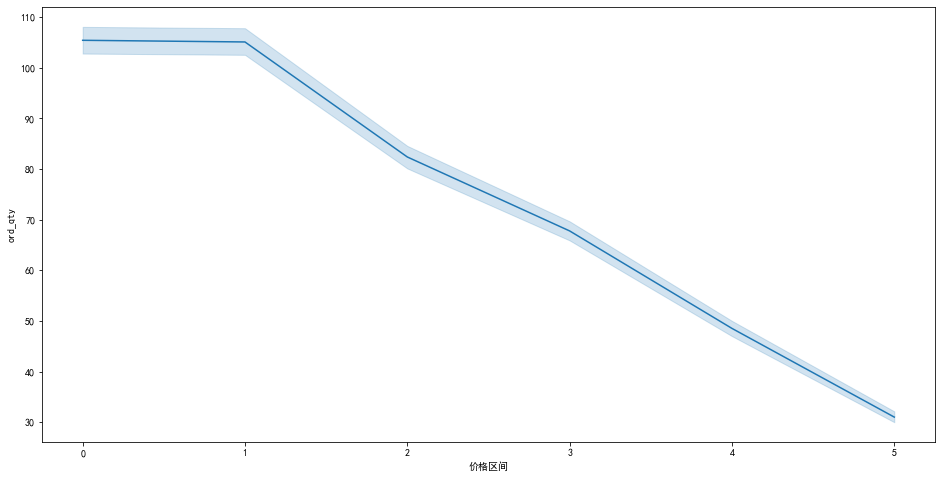

In [560]:
#价格大类的分布情况
plt.figure(figsize=(16,8))
plt.rcParams['font.sans-serif']='simhei'
plt.rcParams['axes.unicode_minus']=False
sns.lineplot(x='价格区间', y='ord_qty', data=df)
plt.show()

In [561]:
df.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,Year,Month,day,is_holiday,是否促销日,day of the week,is_workday,D,价格区间
0,2015-09-02,104,20028,301,405,1,1005.0,11,2015,9,2,0,0,2,1,1,3
1,2015-09-03,102,20354,303,401,1,1420.0,64,2015,9,3,1,0,3,0,2,4
2,2015-09-04,101,20586,306,407,1,978.0,7,2015,9,4,1,0,4,0,3,3
3,2015-09-04,101,20230,306,407,1,864.0,66,2015,9,4,1,0,4,0,3,2
4,2015-09-04,105,21619,306,402,0,274.0,102,2015,9,4,1,0,4,0,3,0


每个地区季节再进行分类和标签编码

In [562]:
df["season"] = df["Month"].map({3:"春季",4:"春季",5:"春季",6:"夏季",7:"夏季",
                                        8:"夏季",9:"秋季",10:"秋季",11:"秋季",12:"冬季",1:"冬季",2:"冬季"})
df
dict_season = {'春季':0,'夏季':1,'秋季':2,'冬季':3}
df['season_bm'] =df.season.map(dict_season)
df

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,Year,Month,day,is_holiday,是否促销日,day of the week,is_workday,D,价格区间,season,season_bm
0,2015-09-02,104,20028,301,405,1,1005.0,11,2015,9,2,0,0,2,1,1,3,秋季,2
1,2015-09-03,102,20354,303,401,1,1420.0,64,2015,9,3,1,0,3,0,2,4,秋季,2
2,2015-09-04,101,20586,306,407,1,978.0,7,2015,9,4,1,0,4,0,3,3,秋季,2
3,2015-09-04,101,20230,306,407,1,864.0,66,2015,9,4,1,0,4,0,3,2,秋季,2
4,2015-09-04,105,21619,306,402,0,274.0,102,2015,9,4,1,0,4,0,3,0,秋季,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58099,2018-12-20,103,20337,302,408,1,799.0,2,2018,12,20,0,0,3,1,1206,2,冬季,3
58100,2018-12-20,103,20146,306,402,1,327.0,87,2018,12,20,0,0,3,1,1206,0,冬季,3
58101,2018-12-20,103,21911,306,407,1,1006.0,2,2018,12,20,0,0,3,1,1206,3,冬季,3
58102,2018-12-20,102,21195,302,408,1,1855.0,134,2018,12,20,0,0,3,1,1206,5,冬季,3


删除无用列，整理df

In [563]:
df.drop(['item_price','season'],axis=1,inplace=True)
df

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,ord_qty,Year,Month,day,is_holiday,是否促销日,day of the week,is_workday,D,价格区间,season_bm
0,2015-09-02,104,20028,301,405,1,11,2015,9,2,0,0,2,1,1,3,2
1,2015-09-03,102,20354,303,401,1,64,2015,9,3,1,0,3,0,2,4,2
2,2015-09-04,101,20586,306,407,1,7,2015,9,4,1,0,4,0,3,3,2
3,2015-09-04,101,20230,306,407,1,66,2015,9,4,1,0,4,0,3,2,2
4,2015-09-04,105,21619,306,402,0,102,2015,9,4,1,0,4,0,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58099,2018-12-20,103,20337,302,408,1,2,2018,12,20,0,0,3,1,1206,2,3
58100,2018-12-20,103,20146,306,402,1,87,2018,12,20,0,0,3,1,1206,0,3
58101,2018-12-20,103,21911,306,407,1,2,2018,12,20,0,0,3,1,1206,3,3
58102,2018-12-20,102,21195,302,408,1,134,2018,12,20,0,0,3,1,1206,5,3


增加待预测的三个月数据（2019年1,2,3,月）

In [565]:
df['zuhe'] = df['sales_region_code'].astype(str)+'_'+df['first_cate_code'].astype(str)+'_'+df['second_cate_code'].astype(str)+'_'+df['item_code'].astype(str)
df.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,ord_qty,Year,Month,day,is_holiday,是否促销日,day of the week,is_workday,D,价格区间,season_bm,zuhe
0,2015-09-02,104,20028,301,405,1,11,2015,9,2,0,0,2,1,1,3,2,104_301_405_20028
1,2015-09-03,102,20354,303,401,1,64,2015,9,3,1,0,3,0,2,4,2,102_303_401_20354
2,2015-09-04,101,20586,306,407,1,7,2015,9,4,1,0,4,0,3,3,2,101_306_407_20586
3,2015-09-04,101,20230,306,407,1,66,2015,9,4,1,0,4,0,3,2,2,101_306_407_20230
4,2015-09-04,105,21619,306,402,0,102,2015,9,4,1,0,4,0,3,0,2,105_306_402_21619


## 增加待预测的三个月数据

In [566]:
len(set(df['zuhe']))
## 现阶段给出的数据，有3849种，我们将先构造一下这3849种产品，每天的需求量为0，加入到原数据中
#先预测一个月的，再将一个月的数据加入到原始作为训练集，再去预测第二个月的，
#意思是先预测出3849种产品2019-1月的需求量，再去预测2019-2，最后时2019-3月。

3849

In [567]:
#从2018-12-21到2019-1-31日的数据

dt1 = pd.date_range(start="20181221", end="20190131", freq="D")
dt1
len(dt1)


42

In [568]:
dates=[]
need=[]
ids =[]
for d in dt1:
    date = str(d).split(' ')[0] #得到日期xx-xx-xx
    dates=dates+[date]*len(set(df['zuhe']))
    need = need+[0]*len(set(df['zuhe']))
    ids=ids+list(set(df['zuhe']))

In [ ]:
#

In [569]:
tempdf=pd.DataFrame()
tempdf['order_date']=dates
tempdf['zuhe']=ids
tempdf['ord_qty']=need
tempdf

,order_date,zuhe,ord_qty
0,2018-12-21,105_303_401_20980,0
1,2018-12-21,102_305_412_20656,0
2,2018-12-21,105_302_408_20747,0
3,2018-12-21,101_303_401_21250,0
4,2018-12-21,103_305_412_21920,0
...,...,...,...
161653,2019-01-31,103_306_407_21467,0
161654,2019-01-31,101_306_407_20067,0
161655,2019-01-31,101_306_407_21206,0
161656,2019-01-31,105_302_408_20465,0


#处理tempdf为df的数据格式：

In [571]:
tempdf['sales_region_code']=tempdf['zuhe'].str.split('_',expand=True)[0]
tempdf['first_cate_code']=tempdf['zuhe'].str.split('_',expand=True)[1]
tempdf['second_cate_code']=tempdf['zuhe'].str.split('_',expand=True)[2]
tempdf['item_code']=tempdf['zuhe'].str.split('_',expand=True)[3]
tempdf.head()

,order_date,zuhe,ord_qty,sales_region_code,first_cate_code,second_cate_code,item_code
0,2018-12-21,105_303_401_20980,0,105,303,401,20980
1,2018-12-21,102_305_412_20656,0,102,305,412,20656
2,2018-12-21,105_302_408_20747,0,105,302,408,20747
3,2018-12-21,101_303_401_21250,0,101,303,401,21250
4,2018-12-21,103_305_412_21920,0,103,305,412,21920


In [572]:
## 
import chinese_calendar
import datetime

tempdf['order_date'] = pd.to_datetime(tempdf['order_date'])  #对日期列进行日期格式转换
tempdf['Year'] = tempdf.order_date.dt.year #分解出年份
tempdf['Month'] = tempdf.order_date.dt.month
tempdf['day'] = tempdf.order_date.dt.day

import datetime
from chinese_calendar import is_holiday, is_workday
is_holidays =[]  #用来存放日期是否为节假日。1为是，0为不是
for index,row in tempdf.iterrows():
    day = datetime.date(int(row['Year']), int(row['Month']),int(row['day']))
    if is_holiday(day):
        is_holidays.append(1)
    else:
        is_holidays.append(0)
tempdf['是否节假日'] = is_holidays  #加入到表格汇总
tempdf.head()

,order_date,zuhe,ord_qty,sales_region_code,first_cate_code,second_cate_code,item_code,Year,Month,day,是否节假日
0,2018-12-21,105_303_401_20980,0,105,303,401,20980,2018,12,21,0
1,2018-12-21,102_305_412_20656,0,102,305,412,20656,2018,12,21,0
2,2018-12-21,105_302_408_20747,0,105,302,408,20747,2018,12,21,0
3,2018-12-21,101_303_401_21250,0,101,303,401,21250,2018,12,21,0
4,2018-12-21,103_305_412_21920,0,103,305,412,21920,2018,12,21,0


In [573]:
#自定义促销日期： 促销日有很多，我们随便选10个代表性的促销日期进行数据统计
list_cux = ['1-1','4-1','2-14','3-1','3-8','4-11','5-1','6-1','6-18','11-11','12-12']
cuxs=[]

#再得到日期是否是自己自定义的促销日：
for index ,row in tempdf.iterrows():
    str_date = str(row['Month'])+'-'+str(row['day'])
    if str_date in list_cux:
#         print(str_date)
        cuxs.append(1)
    else:
        cuxs.append(0)


tempdf['是否促销日']=cuxs
tempdf.head()

,order_date,zuhe,ord_qty,sales_region_code,first_cate_code,second_cate_code,item_code,Year,Month,day,是否节假日,是否促销日
0,2018-12-21,105_303_401_20980,0,105,303,401,20980,2018,12,21,0,0
1,2018-12-21,102_305_412_20656,0,102,305,412,20656,2018,12,21,0,0
2,2018-12-21,105_302_408_20747,0,105,302,408,20747,2018,12,21,0,0
3,2018-12-21,101_303_401_21250,0,101,303,401,21250,2018,12,21,0,0
4,2018-12-21,103_305_412_21920,0,103,305,412,21920,2018,12,21,0,0


In [574]:
jagdf=df[['zuhe','价格区间','sales_chan_name']]
jagdf.drop_duplicates(['zuhe'],keep='last',inplace=True)
jagdf

,zuhe,价格区间,sales_chan_name
0,104_301_405_20028,3,1
19,102_306_407_20964,4,1
47,101_306_407_20096,3,1
134,102_306_407_20855,5,1
140,101_303_401_21187,0,1
...,...,...,...
58099,103_302_408_20337,2,1
58100,103_306_402_20146,0,1
58101,103_306_407_21911,3,1
58102,102_302_408_21195,5,1


In [575]:
dict_jg = {}
qudao_dict={}
for i in range(len(jagdf)):
    dict_jg[list(jagdf['zuhe'])[i]]=list(jagdf['价格区间'])[i]
    qudao_dict[list(jagdf['zuhe'])[i]] = list(jagdf['sales_chan_name'])[i]
dict_jg
qudao_dict

{'104_301_405_20028': 1,
 '102_306_407_20964': 1,
 '101_306_407_20096': 1,
 '102_306_407_20855': 1,
 '101_303_401_21187': 1,
 '104_307_403_21565': 1,
 '105_303_401_20354': 1,
 '105_306_407_20883': 1,
 '101_303_401_20354': 1,
 '103_303_401_20598': 1,
 '101_306_407_21402': 1,
 '102_306_407_20671': 1,
 '102_306_407_21600': 1,
 '105_303_401_20487': 0,
 '102_302_408_21273': 1,
 '105_305_412_21673': 0,
 '102_306_407_21402': 1,
 '104_307_403_22069': 1,
 '104_307_403_21315': 0,
 '103_306_407_21888': 1,
 '103_306_407_21861': 1,
 '101_303_401_21519': 1,
 '102_303_401_21519': 1,
 '103_305_412_21985': 1,
 '102_306_407_21616': 1,
 '102_306_407_20579': 1,
 '102_306_407_20378': 1,
 '101_303_401_21499': 1,
 '104_307_403_20233': 0,
 '101_306_407_21789': 1,
 '101_306_407_20970': 1,
 '101_303_401_21146': 1,
 '105_306_407_21799': 1,
 '101_306_407_21888': 1,
 '103_306_407_20378': 1,
 '102_306_407_20680': 1,
 '104_308_404_21226': 0,
 '102_302_408_21024': 1,
 '102_305_412_20007': 1,
 '101_305_412_21673': 1,


In [576]:
#价格区间：
jiage=[]
qudao =[]
for v in tempdf['zuhe']:
    jiage.append(dict_jg[v])
    qudao.append(qudao_dict[v])
tempdf['价格区间']=jiage
tempdf['sales_chan_name']=qudao
tempdf

,order_date,zuhe,ord_qty,sales_region_code,first_cate_code,second_cate_code,item_code,Year,Month,day,是否节假日,是否促销日,价格区间,sales_chan_name
0,2018-12-21,105_303_401_20980,0,105,303,401,20980,2018,12,21,0,0,4,1
1,2018-12-21,102_305_412_20656,0,102,305,412,20656,2018,12,21,0,0,0,1
2,2018-12-21,105_302_408_20747,0,105,302,408,20747,2018,12,21,0,0,4,1
3,2018-12-21,101_303_401_21250,0,101,303,401,21250,2018,12,21,0,0,4,1
4,2018-12-21,103_305_412_21920,0,103,305,412,21920,2018,12,21,0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161653,2019-01-31,103_306_407_21467,0,103,306,407,21467,2019,1,31,0,0,4,1
161654,2019-01-31,101_306_407_20067,0,101,306,407,20067,2019,1,31,0,0,5,1
161655,2019-01-31,101_306_407_21206,0,101,306,407,21206,2019,1,31,0,0,4,0
161656,2019-01-31,105_302_408_20465,0,105,302,408,20465,2019,1,31,0,0,5,1


In [577]:
tempdf['标签'] = "空"

for index,row in tempdf.iterrows():
    ts = pd.Timestamp(row['Year'],row['Month'],row['day'])
    end=ts+pd.offsets.MonthEnd()
    if row['order_date'] < pd.to_datetime(end) and row['order_date'] <=pd.to_datetime(pd.Timestamp(row['Year'],row['Month'],10)):
        tempdf.at[index,'标签'] = "月初"
    elif pd.to_datetime(pd.Timestamp(row['Year'], row['Month'],10))< row['order_date']  <=pd.to_datetime(pd.Timestamp(row['Year'],row['Month'],20)):
        tempdf.at[index,'标签'] = "月中" 
    else:
        tempdf.at[index,'标签'] = "月末" 
                        
tempdf

,order_date,zuhe,ord_qty,sales_region_code,first_cate_code,second_cate_code,item_code,Year,Month,day,是否节假日,是否促销日,价格区间,sales_chan_name,标签
0,2018-12-21,105_303_401_20980,0,105,303,401,20980,2018,12,21,0,0,4,1,月末
1,2018-12-21,102_305_412_20656,0,102,305,412,20656,2018,12,21,0,0,0,1,月末
2,2018-12-21,105_302_408_20747,0,105,302,408,20747,2018,12,21,0,0,4,1,月末
3,2018-12-21,101_303_401_21250,0,101,303,401,21250,2018,12,21,0,0,4,1,月末
4,2018-12-21,103_305_412_21920,0,103,305,412,21920,2018,12,21,0,0,3,1,月末
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161653,2019-01-31,103_306_407_21467,0,103,306,407,21467,2019,1,31,0,0,4,1,月末
161654,2019-01-31,101_306_407_20067,0,101,306,407,20067,2019,1,31,0,0,5,1,月末
161655,2019-01-31,101_306_407_21206,0,101,306,407,21206,2019,1,31,0,0,4,0,月末
161656,2019-01-31,105_302_408_20465,0,105,302,408,20465,2019,1,31,0,0,5,1,月末


In [578]:
tempdf["season"] = tempdf["Month"].map({3:"春季",4:"春季",5:"春季",6:"夏季",7:"夏季",
                                        8:"夏季",9:"秋季",10:"秋季",11:"秋季",12:"冬季",1:"冬季",2:"冬季"})
dict_season = {'春季':0,'夏季':1,'秋季':2,'冬季':3}
tempdf['season_bm'] =tempdf.season.map(dict_season)
dict_moth = {'月初':0,'月中':1,'月末':2}
tempdf['每月时间段'] =tempdf.标签.map(dict_moth)
tempdf

,order_date,zuhe,ord_qty,sales_region_code,first_cate_code,second_cate_code,item_code,Year,Month,day,是否节假日,是否促销日,价格区间,sales_chan_name,标签,season,season_bm,每月时间段
0,2018-12-21,105_303_401_20980,0,105,303,401,20980,2018,12,21,0,0,4,1,月末,冬季,3,2
1,2018-12-21,102_305_412_20656,0,102,305,412,20656,2018,12,21,0,0,0,1,月末,冬季,3,2
2,2018-12-21,105_302_408_20747,0,105,302,408,20747,2018,12,21,0,0,4,1,月末,冬季,3,2
3,2018-12-21,101_303_401_21250,0,101,303,401,21250,2018,12,21,0,0,4,1,月末,冬季,3,2
4,2018-12-21,103_305_412_21920,0,103,305,412,21920,2018,12,21,0,0,3,1,月末,冬季,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161653,2019-01-31,103_306_407_21467,0,103,306,407,21467,2019,1,31,0,0,4,1,月末,冬季,3,2
161654,2019-01-31,101_306_407_20067,0,101,306,407,20067,2019,1,31,0,0,5,1,月末,冬季,3,2
161655,2019-01-31,101_306_407_21206,0,101,306,407,21206,2019,1,31,0,0,4,0,月末,冬季,3,2
161656,2019-01-31,105_302_408_20465,0,105,302,408,20465,2019,1,31,0,0,5,1,月末,冬季,3,2


In [579]:
tempdf['星期几'] = tempdf.order_date.dt.weekday   #0-6  {0, 1, 2, 3, 4, 5, 6}

tempdf['is_workday']=tempdf['order_date'].map(lambda x:is_workday(x))

dict_is_workday = {False:0,True:1}
tempdf['is_workday'] =tempdf.is_workday.map(dict_is_workday)
tempdf

,order_date,zuhe,ord_qty,sales_region_code,first_cate_code,second_cate_code,item_code,Year,Month,day,是否节假日,是否促销日,价格区间,sales_chan_name,标签,season,season_bm,每月时间段,星期几,is_workday
0,2018-12-21,105_303_401_20980,0,105,303,401,20980,2018,12,21,0,0,4,1,月末,冬季,3,2,4,1
1,2018-12-21,102_305_412_20656,0,102,305,412,20656,2018,12,21,0,0,0,1,月末,冬季,3,2,4,1
2,2018-12-21,105_302_408_20747,0,105,302,408,20747,2018,12,21,0,0,4,1,月末,冬季,3,2,4,1
3,2018-12-21,101_303_401_21250,0,101,303,401,21250,2018,12,21,0,0,4,1,月末,冬季,3,2,4,1
4,2018-12-21,103_305_412_21920,0,103,305,412,21920,2018,12,21,0,0,3,1,月末,冬季,3,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161653,2019-01-31,103_306_407_21467,0,103,306,407,21467,2019,1,31,0,0,4,1,月末,冬季,3,2,3,1
161654,2019-01-31,101_306_407_20067,0,101,306,407,20067,2019,1,31,0,0,5,1,月末,冬季,3,2,3,1
161655,2019-01-31,101_306_407_21206,0,101,306,407,21206,2019,1,31,0,0,4,0,月末,冬季,3,2,3,1
161656,2019-01-31,105_302_408_20465,0,105,302,408,20465,2019,1,31,0,0,5,1,月末,冬季,3,2,3,1


In [580]:
tempdf.drop(['标签','season','zuhe'],axis=1,inplace=True)

In [581]:
tempdf

,order_date,ord_qty,sales_region_code,first_cate_code,second_cate_code,item_code,Year,Month,day,是否节假日,是否促销日,价格区间,sales_chan_name,season_bm,每月时间段,星期几,is_workday
0,2018-12-21,0,105,303,401,20980,2018,12,21,0,0,4,1,3,2,4,1
1,2018-12-21,0,102,305,412,20656,2018,12,21,0,0,0,1,3,2,4,1
2,2018-12-21,0,105,302,408,20747,2018,12,21,0,0,4,1,3,2,4,1
3,2018-12-21,0,101,303,401,21250,2018,12,21,0,0,4,1,3,2,4,1
4,2018-12-21,0,103,305,412,21920,2018,12,21,0,0,3,1,3,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161653,2019-01-31,0,103,306,407,21467,2019,1,31,0,0,4,1,3,2,3,1
161654,2019-01-31,0,101,306,407,20067,2019,1,31,0,0,5,1,3,2,3,1
161655,2019-01-31,0,101,306,407,21206,2019,1,31,0,0,4,0,3,2,3,1
161656,2019-01-31,0,105,302,408,20465,2019,1,31,0,0,5,1,3,2,3,1


In [583]:
dt1 = pd.date_range(start="20150902", end="20190131", freq="D")
dt1
dicts = {}
i =1
for date in dt1:
    dicts[str(date).split(' ')[0]]=i
    i+=1
dicts
Ds=[]
for dat in tempdf['order_date']:
    Ds.append(dicts[str(dat).split(' ')[0]])
tempdf['D'] = Ds
tempdf

,order_date,ord_qty,sales_region_code,first_cate_code,second_cate_code,item_code,Year,Month,day,是否节假日,是否促销日,价格区间,sales_chan_name,season_bm,每月时间段,星期几,is_workday,D
0,2018-12-21,0,105,303,401,20980,2018,12,21,0,0,4,1,3,2,4,1,1207
1,2018-12-21,0,102,305,412,20656,2018,12,21,0,0,0,1,3,2,4,1,1207
2,2018-12-21,0,105,302,408,20747,2018,12,21,0,0,4,1,3,2,4,1,1207
3,2018-12-21,0,101,303,401,21250,2018,12,21,0,0,4,1,3,2,4,1,1207
4,2018-12-21,0,103,305,412,21920,2018,12,21,0,0,3,1,3,2,4,1,1207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161653,2019-01-31,0,103,306,407,21467,2019,1,31,0,0,4,1,3,2,3,1,1248
161654,2019-01-31,0,101,306,407,20067,2019,1,31,0,0,5,1,3,2,3,1,1248
161655,2019-01-31,0,101,306,407,21206,2019,1,31,0,0,4,0,3,2,3,1,1248
161656,2019-01-31,0,105,302,408,20465,2019,1,31,0,0,5,1,3,2,3,1,1248


In [584]:
tempdf.columns

Index(['order_date', 'ord_qty', 'sales_region_code', 'first_cate_code',
       'second_cate_code', 'item_code', 'Year', 'Month', 'day', '是否节假日',
       '是否促销日', '价格区间', 'sales_chan_name', 'season_bm', '每月时间段', '星期几',
       'is_workday', 'D'],
      dtype='object')

In [585]:
df_sub=tempdf[['order_date','sales_region_code','item_code','first_cate_code',
       'second_cate_code', 'sales_chan_name' ,'ord_qty', 'Year','Month', 'day',
       '是否节假日', '是否促销日', 'D', '价格区间', 'season_bm',
       '星期几', 'is_workday',]]
df_sub

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,ord_qty,Year,Month,day,是否节假日,是否促销日,D,价格区间,season_bm,星期几,is_workday
0,2018-12-21,105,20980,303,401,1,0,2018,12,21,0,0,1207,4,3,4,1
1,2018-12-21,102,20656,305,412,1,0,2018,12,21,0,0,1207,0,3,4,1
2,2018-12-21,105,20747,302,408,1,0,2018,12,21,0,0,1207,4,3,4,1
3,2018-12-21,101,21250,303,401,1,0,2018,12,21,0,0,1207,4,3,4,1
4,2018-12-21,103,21920,305,412,1,0,2018,12,21,0,0,1207,3,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161653,2019-01-31,103,21467,306,407,1,0,2019,1,31,0,0,1248,4,3,3,1
161654,2019-01-31,101,20067,306,407,1,0,2019,1,31,0,0,1248,5,3,3,1
161655,2019-01-31,101,21206,306,407,0,0,2019,1,31,0,0,1248,4,3,3,1
161656,2019-01-31,105,20465,302,408,1,0,2019,1,31,0,0,1248,5,3,3,1


In [586]:
df_sub[['sales_chan_name','item_code','first_cate_code','second_cate_code',]] = df_sub[['sales_chan_name','item_code','first_cate_code','second_cate_code',]].apply(pd.to_numeric)
df_sub['价格区间']=df_sub['价格区间'].astype('category')
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161658 entries, 0 to 161657
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   order_date         161658 non-null  datetime64[ns]
 1   sales_region_code  161658 non-null  object        
 2   item_code          161658 non-null  int64         
 3   first_cate_code    161658 non-null  int64         
 4   second_cate_code   161658 non-null  int64         
 5   sales_chan_name    161658 non-null  int64         
 6   ord_qty            161658 non-null  int64         
 7   Year               161658 non-null  int64         
 8   Month              161658 non-null  int64         
 9   day                161658 non-null  int64         
 10  是否节假日              161658 non-null  int64         
 11  是否促销日              161658 non-null  int64         
 12  D                  161658 non-null  int64         
 13  价格区间               161658 non-null  category

In [589]:
# b保存一下构造的19年1月数据：
df_sub.to_csv('19_01data.csv',index=False,)

In [590]:
df.drop('zuhe',axis=1,inplace=True)  #删除df的无用列

整理df和df_sub使能够合并，这里列名不一致，改改名称

In [593]:
df.columns

Index(['order_date', 'sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'ord_qty', 'Year', 'Month',
       'day', '是否节假日', '是否促销日', 'season_bm', '价格区间', 'D', '星期几', 'is_workday'],
      dtype='object')

In [594]:
df.columns = ['order_date', 'sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'ord_qty', 'Year', 'Month',
       'day', '是否节假日', '是否促销日',  'season_bm','价格区间', 'D', '星期几', 'is_workday']

In [595]:
df[['order_date', 'sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'ord_qty', 'Year', 'Month',
       'day', '是否节假日', '是否促销日', 'D' ,'价格区间', 'season_bm', '星期几', 'is_workday']]

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,ord_qty,Year,Month,day,是否节假日,是否促销日,D,价格区间,season_bm,星期几,is_workday
0,2015-09-02,104,20028,301,405,1,11,2015,9,2,0,0,1,1,2,3,2
1,2015-09-03,102,20354,303,401,1,64,2015,9,3,1,0,2,0,3,4,2
2,2015-09-04,101,20586,306,407,1,7,2015,9,4,1,0,3,0,4,3,2
3,2015-09-04,101,20230,306,407,1,66,2015,9,4,1,0,3,0,4,2,2
4,2015-09-04,105,21619,306,402,0,102,2015,9,4,1,0,3,0,4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58099,2018-12-20,103,20337,302,408,1,2,2018,12,20,0,0,1206,1,3,2,3
58100,2018-12-20,103,20146,306,402,1,87,2018,12,20,0,0,1206,1,3,0,3
58101,2018-12-20,103,21911,306,407,1,2,2018,12,20,0,0,1206,1,3,3,3
58102,2018-12-20,102,21195,302,408,1,134,2018,12,20,0,0,1206,1,3,5,3


In [596]:
df_sub.columns

Index(['order_date', 'sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'ord_qty', 'Year', 'Month',
       'day', '是否节假日', '是否促销日', 'D', '价格区间', 'season_bm', '星期几', 'is_workday'],
      dtype='object')

In [600]:
df_sub[['order_date', 'sales_region_code', 'item_code', 'first_cate_code',
       'second_cate_code', 'sales_chan_name', 'ord_qty', 'Year', 'Month',
       'day', '是否节假日', '是否促销日', 'season_bm', '价格区间','D', '星期几','is_workday']]

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,ord_qty,Year,Month,day,是否节假日,是否促销日,season_bm,价格区间,D,星期几,is_workday
0,2018-12-21,105,20980,303,401,1,0,2018,12,21,0,0,3,4,1207,4,1
1,2018-12-21,102,20656,305,412,1,0,2018,12,21,0,0,3,0,1207,4,1
2,2018-12-21,105,20747,302,408,1,0,2018,12,21,0,0,3,4,1207,4,1
3,2018-12-21,101,21250,303,401,1,0,2018,12,21,0,0,3,4,1207,4,1
4,2018-12-21,103,21920,305,412,1,0,2018,12,21,0,0,3,3,1207,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161653,2019-01-31,103,21467,306,407,1,0,2019,1,31,0,0,3,4,1248,3,1
161654,2019-01-31,101,20067,306,407,1,0,2019,1,31,0,0,3,5,1248,3,1
161655,2019-01-31,101,21206,306,407,0,0,2019,1,31,0,0,3,4,1248,3,1
161656,2019-01-31,105,20465,302,408,1,0,2019,1,31,0,0,3,5,1248,3,1


In [599]:
df

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,ord_qty,Year,Month,day,是否节假日,是否促销日,season_bm,价格区间,D,星期几,is_workday
0,2015-09-02,104,20028,301,405,1,11,2015,9,2,0,0,2,1,1,3,2
1,2015-09-03,102,20354,303,401,1,64,2015,9,3,1,0,3,0,2,4,2
2,2015-09-04,101,20586,306,407,1,7,2015,9,4,1,0,4,0,3,3,2
3,2015-09-04,101,20230,306,407,1,66,2015,9,4,1,0,4,0,3,2,2
4,2015-09-04,105,21619,306,402,0,102,2015,9,4,1,0,4,0,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58099,2018-12-20,103,20337,302,408,1,2,2018,12,20,0,0,3,1,1206,2,3
58100,2018-12-20,103,20146,306,402,1,87,2018,12,20,0,0,3,1,1206,0,3
58101,2018-12-20,103,21911,306,407,1,2,2018,12,20,0,0,3,1,1206,3,3
58102,2018-12-20,102,21195,302,408,1,134,2018,12,20,0,0,3,1,1206,5,3


#拼接df_sub和df：

In [601]:
df1 =pd.concat([df,df_sub],axis=0)
df1

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,ord_qty,Year,Month,day,是否节假日,是否促销日,season_bm,价格区间,D,星期几,is_workday
0,2015-09-02,104,20028,301,405,1,11,2015,9,2,0,0,2,1,1,3,2
1,2015-09-03,102,20354,303,401,1,64,2015,9,3,1,0,3,0,2,4,2
2,2015-09-04,101,20586,306,407,1,7,2015,9,4,1,0,4,0,3,3,2
3,2015-09-04,101,20230,306,407,1,66,2015,9,4,1,0,4,0,3,2,2
4,2015-09-04,105,21619,306,402,0,102,2015,9,4,1,0,4,0,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161653,2019-01-31,103,21467,306,407,1,0,2019,1,31,0,0,3,4,1248,3,1
161654,2019-01-31,101,20067,306,407,1,0,2019,1,31,0,0,3,5,1248,3,1
161655,2019-01-31,101,21206,306,407,0,0,2019,1,31,0,0,3,4,1248,3,1
161656,2019-01-31,105,20465,302,408,1,0,2019,1,31,0,0,3,5,1248,3,1


In [602]:
df=df1
df 

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,ord_qty,Year,Month,day,是否节假日,是否促销日,season_bm,价格区间,D,星期几,is_workday
0,2015-09-02,104,20028,301,405,1,11,2015,9,2,0,0,2,1,1,3,2
1,2015-09-03,102,20354,303,401,1,64,2015,9,3,1,0,3,0,2,4,2
2,2015-09-04,101,20586,306,407,1,7,2015,9,4,1,0,4,0,3,3,2
3,2015-09-04,101,20230,306,407,1,66,2015,9,4,1,0,4,0,3,2,2
4,2015-09-04,105,21619,306,402,0,102,2015,9,4,1,0,4,0,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161653,2019-01-31,103,21467,306,407,1,0,2019,1,31,0,0,3,4,1248,3,1
161654,2019-01-31,101,20067,306,407,1,0,2019,1,31,0,0,3,5,1248,3,1
161655,2019-01-31,101,21206,306,407,0,0,2019,1,31,0,0,3,4,1248,3,1
161656,2019-01-31,105,20465,302,408,1,0,2019,1,31,0,0,3,5,1248,3,1


In [603]:
df.info()#无缺失值

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219762 entries, 0 to 161657
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   order_date         219762 non-null  datetime64[ns]
 1   sales_region_code  219762 non-null  object        
 2   item_code          219762 non-null  int64         
 3   first_cate_code    219762 non-null  int64         
 4   second_cate_code   219762 non-null  int64         
 5   sales_chan_name    219762 non-null  int64         
 6   ord_qty            219762 non-null  int64         
 7   Year               219762 non-null  int64         
 8   Month              219762 non-null  int64         
 9   day                219762 non-null  int64         
 10  是否节假日              219762 non-null  int64         
 11  是否促销日              219762 non-null  int64         
 12  season_bm          219762 non-null  int64         
 13  价格区间               219762 non-null  int64   

# 特征工程

## 滞后特征

滞后特征是将时间序列预测问题转化为监督学习问题的经典方法。

对销售的目标变量引入滞后。我使用的最大延迟是60天。这完全取决于你想引入多少滞后。


In [604]:
#Introduce lags
lags = [1,2,3,6,12,24,36,48,60]
for lag in lags:
    df['need_lag_'+str(lag)] = df.groupby(['sales_chan_name','item_code','first_cate_code','second_cate_code',],as_index=False)['ord_qty'].shift(lag).astype(np.float16)

##  均值编码

从数学的角度来看，均值编码表示目标变量的概率，条件是特征的每个值。在某种程度上，它将目标变量体现在其编码值中。我根据我能想到的以下逻辑特征计算出了平均编码:-

产品编码

销售区域编码

产品大类编码

产品细类编码

销售渠道名称

销售区域编码 and 产品编码

产品大类编码 and 产品编码

产品细类编码 and 产品编码

销售渠道名称 and 产品编码

销售区域编码 and 产品大类编码

产品大类编码 and 产品细类编码

销售渠道名称 and 产品细类编码

In [605]:
s =  df.groupby('item_code')['ord_qty'].transform('mean')

In [606]:
df['产品编码_avg'] = df.groupby('item_code')['ord_qty'].transform('mean').astype(np.float16)
df['销售区域编码_need_avg'] = df.groupby( 'sales_region_code')['ord_qty'].transform('mean').astype(np.float16)
df['产品大类编码_need_avg'] = df.groupby('first_cate_code')['ord_qty'].transform('mean').astype(np.float16)
df['产品细类编码_need_avg'] = df.groupby('second_cate_code')['ord_qty'].transform('mean').astype(np.float16)
df['销售渠道名称_need_avg'] = df.groupby('sales_chan_name')['ord_qty'].transform('mean').astype(np.float16)
df['销售区域编码_产品编码_need_avg'] = df.groupby(['item_code','sales_region_code'])['ord_qty'].transform('mean').astype(np.float16)
df['产品大类编码_产品编码_need_avg'] = df.groupby(['first_cate_code','item_code'])['ord_qty'].transform('mean').astype(np.float16)
df['产品细类编码_产品编码_need_avg'] = df.groupby(['second_cate_code','item_code'])['ord_qty'].transform('mean').astype(np.float16)
df['销售渠道名称_产品编码_need_avg'] = df.groupby(['sales_chan_name','item_code'])['ord_qty'].transform('mean').astype(np.float16)
df['销售区域编码_产品大类编码_need_avg'] = df.groupby(['sales_chan_name','first_cate_code'])['ord_qty'].transform('mean').astype(np.float16)
df['产品大类编码_产品细类编码_need_avg'] = df.groupby(['first_cate_code','second_cate_code'])['ord_qty'].transform('mean').astype(np.float16)
df['销售渠道名称_产品细类编码_need_avg'] = df.groupby(['sales_chan_name','second_cate_code'])['ord_qty'].transform('mean').astype(np.float16)

In [607]:
df

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,ord_qty,Year,Month,day,是否节假日,是否促销日,season_bm,价格区间,D,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg
0,2015-09-02,104,20028,301,405,1,11,2015,9,2,0,0,2,1,1,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.186035,78.3125,22.000000,22.000000,18.031250,11.00000,0.186035,0.186035,0.186035,12.484375,22.000000,12.484375
1,2015-09-03,102,20354,303,401,1,64,2015,9,3,1,0,3,0,2,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.601562,74.8750,11.523438,13.570312,18.031250,33.15625,1.601562,1.601562,1.601562,11.242188,13.570312,13.781250
2,2015-09-04,101,20586,306,407,1,7,2015,9,4,1,0,4,0,3,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.101562,76.8125,26.328125,25.390625,18.031250,27.78125,15.101562,15.101562,15.101562,25.375000,25.390625,24.906250
3,2015-09-04,101,20230,306,407,1,66,2015,9,4,1,0,4,0,3,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.750000,76.8125,26.328125,25.390625,18.031250,76.75000,40.750000,40.750000,46.281250,25.375000,25.390625,24.906250
4,2015-09-04,105,21619,306,402,0,102,2015,9,4,1,0,4,0,3,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.000000,64.8750,26.328125,49.843750,23.671875,141.37500,112.000000,112.000000,121.500000,29.859375,49.843750,77.312500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161653,2019-01-31,103,21467,306,407,1,0,2019,1,31,0,0,3,4,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.949219,0.0000,26.328125,25.390625,18.031250,0.00000,4.949219,4.949219,4.949219,25.375000,25.390625,24.906250
161654,2019-01-31,101,20067,306,407,1,0,2019,1,31,0,0,3,5,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.007812,0.0000,26.328125,25.390625,18.031250,0.00000,5.007812,5.007812,5.007812,25.375000,25.390625,24.906250
161655,2019-01-31,101,21206,306,407,0,0,2019,1,31,0,0,3,4,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.673828,0.0000,26.328125,25.390625,23.671875,0.00000,2.673828,2.673828,3.687500,29.859375,25.390625,27.234375
161656,2019-01-31,105,20465,302,408,1,0,2019,1,31,0,0,3,5,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.669922,0.0000,12.398438,12.398438,18.031250,0.00000,3.669922,3.669922,3.669922,10.546875,12.398438,10.546875


## 滑动窗口统计

In [608]:
#计算每周销售的滚动平均数。更多的特征，如滚动最小值，最大值或总和也可以计算。同样，同样的功能也可以用于计算需求量。
df['rolling_need_mean'] = df.groupby(['sales_chan_name','item_code','first_cate_code','second_cate_code'])['ord_qty'].transform(lambda x: x.rolling(window=7).mean()).astype(np.float16)

## 开窗数据拓展

In [609]:
'''
开窗数据拓展
这是滚动窗口技术的高级版本。在滚动窗口的情况下，当窗口随着时间向前移动而滑动时，
窗口的大小是恒定的。因此，我们只考虑最近的值，而忽略过去的值。 我将计算需求量的
扩大平均值。还可以计算更多的特征，如扩展最小值、最大值或总和。同样，同样的功能
也可以用于计算需求量。
'''

df['expanding_need_mean'] = df.groupby(['sales_chan_name','item_code','first_cate_code','second_cate_code'])['ord_qty'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

## 需求量趋势构建

#需求量趋势构建
'''
我将创建一个需求量趋势特征，如果每日需求量大于整个持续时间的平均值(d_1 - d_1206)，
则为负值。可以添加更多的趋势特性，但我只添加这一个以保持简单。
'''

In [610]:
df['daily_avg_need'] = df.groupby(['sales_chan_name','item_code','first_cate_code','second_cate_code','D'])['ord_qty'].transform('mean').astype(np.float16)
df['avg_need'] = df.groupby(['sales_chan_name','item_code','first_cate_code','second_cate_code'])['ord_qty'].transform('mean').astype(np.float16)
df['need_trend'] = (df['daily_avg_need'] - df['avg_need']).astype(np.float16)
df.drop(['daily_avg_need','avg_need'],axis=1,inplace=True)

In [611]:
df2 = df
df2

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,ord_qty,Year,Month,day,是否节假日,是否促销日,season_bm,价格区间,D,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,rolling_need_mean,expanding_need_mean,need_trend
0,2015-09-02,104,20028,301,405,1,11,2015,9,2,0,0,2,1,1,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.186035,78.3125,22.000000,22.000000,18.031250,11.00000,0.186035,0.186035,0.186035,12.484375,22.000000,12.484375,NaN,NaN,10.812500
1,2015-09-03,102,20354,303,401,1,64,2015,9,3,1,0,3,0,2,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.601562,74.8750,11.523438,13.570312,18.031250,33.15625,1.601562,1.601562,1.601562,11.242188,13.570312,13.781250,NaN,NaN,62.406250
2,2015-09-04,101,20586,306,407,1,7,2015,9,4,1,0,4,0,3,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.101562,76.8125,26.328125,25.390625,18.031250,27.78125,15.101562,15.101562,15.101562,25.375000,25.390625,24.906250,NaN,NaN,-8.101562
3,2015-09-04,101,20230,306,407,1,66,2015,9,4,1,0,4,0,3,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.750000,76.8125,26.328125,25.390625,18.031250,76.75000,40.750000,40.750000,46.281250,25.375000,25.390625,24.906250,NaN,NaN,19.718750
4,2015-09-04,105,21619,306,402,0,102,2015,9,4,1,0,4,0,3,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.000000,64.8750,26.328125,49.843750,23.671875,141.37500,112.000000,112.000000,121.500000,29.859375,49.843750,77.312500,NaN,NaN,-19.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161653,2019-01-31,103,21467,306,407,1,0,2019,1,31,0,0,3,4,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.949219,0.0000,26.328125,25.390625,18.031250,0.00000,4.949219,4.949219,4.949219,25.375000,25.390625,24.906250,0.0,4.949219,-4.949219
161654,2019-01-31,101,20067,306,407,1,0,2019,1,31,0,0,3,5,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.007812,0.0000,26.328125,25.390625,18.031250,0.00000,5.007812,5.007812,5.007812,25.375000,25.390625,24.906250,0.0,5.007812,-5.007812
161655,2019-01-31,101,21206,306,407,0,0,2019,1,31,0,0,3,4,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.673828,0.0000,26.328125,25.390625,23.671875,0.00000,2.673828,2.673828,3.687500,29.859375,25.390625,27.234375,0.0,3.687500,-3.687500
161656,2019-01-31,105,20465,302,408,1,0,2019,1,31,0,0,3,5,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.669922,0.0000,12.398438,12.398438,18.031250,0.00000,3.669922,3.669922,3.669922,10.546875,12.398438,10.546875,0.0,3.669922,-3.669922


In [612]:

df2.drop('order_date',axis=1,inplace=True)
df2

,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,ord_qty,Year,Month,day,是否节假日,是否促销日,season_bm,价格区间,D,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,rolling_need_mean,expanding_need_mean,need_trend
0,104,20028,301,405,1,11,2015,9,2,0,0,2,1,1,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.186035,78.3125,22.000000,22.000000,18.031250,11.00000,0.186035,0.186035,0.186035,12.484375,22.000000,12.484375,NaN,NaN,10.812500
1,102,20354,303,401,1,64,2015,9,3,1,0,3,0,2,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.601562,74.8750,11.523438,13.570312,18.031250,33.15625,1.601562,1.601562,1.601562,11.242188,13.570312,13.781250,NaN,NaN,62.406250
2,101,20586,306,407,1,7,2015,9,4,1,0,4,0,3,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.101562,76.8125,26.328125,25.390625,18.031250,27.78125,15.101562,15.101562,15.101562,25.375000,25.390625,24.906250,NaN,NaN,-8.101562
3,101,20230,306,407,1,66,2015,9,4,1,0,4,0,3,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.750000,76.8125,26.328125,25.390625,18.031250,76.75000,40.750000,40.750000,46.281250,25.375000,25.390625,24.906250,NaN,NaN,19.718750
4,105,21619,306,402,0,102,2015,9,4,1,0,4,0,3,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.000000,64.8750,26.328125,49.843750,23.671875,141.37500,112.000000,112.000000,121.500000,29.859375,49.843750,77.312500,NaN,NaN,-19.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161653,103,21467,306,407,1,0,2019,1,31,0,0,3,4,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.949219,0.0000,26.328125,25.390625,18.031250,0.00000,4.949219,4.949219,4.949219,25.375000,25.390625,24.906250,0.0,4.949219,-4.949219
161654,101,20067,306,407,1,0,2019,1,31,0,0,3,5,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.007812,0.0000,26.328125,25.390625,18.031250,0.00000,5.007812,5.007812,5.007812,25.375000,25.390625,24.906250,0.0,5.007812,-5.007812
161655,101,21206,306,407,0,0,2019,1,31,0,0,3,4,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.673828,0.0000,26.328125,25.390625,23.671875,0.00000,2.673828,2.673828,3.687500,29.859375,25.390625,27.234375,0.0,3.687500,-3.687500
161656,105,20465,302,408,1,0,2019,1,31,0,0,3,5,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.669922,0.0000,12.398438,12.398438,18.031250,0.00000,3.669922,3.669922,3.669922,10.546875,12.398438,10.546875,0.0,3.669922,-3.669922


保存数据

In [ ]:
#现在，既然已经创建了所有新特征，让我们保存数据，以便分别对其进行训练。 
#此外，延迟引入了许多Null值，因此我将删除前60天的数据，因为我已经引入了到60天的延迟。

In [613]:
df2 = df2[df2['D']>=60]
df2

,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,ord_qty,Year,Month,day,是否节假日,是否促销日,season_bm,价格区间,D,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,rolling_need_mean,expanding_need_mean,need_trend
1426,102,20973,306,407,1,554,2015,10,31,1,0,5,0,60,1,2,502.0,88.0,211.0,103.0,107.0,NaN,NaN,NaN,NaN,121.375000,74.8750,26.328125,25.390625,18.031250,165.50000,121.375000,121.375000,121.500000,25.375000,25.390625,24.906250,239.25000,248.500000,432.500000
1427,102,20895,306,407,1,54,2015,10,31,1,0,5,0,60,2,2,130.0,79.0,14.0,55.0,NaN,NaN,NaN,NaN,NaN,12.101562,74.8750,26.328125,25.390625,18.031250,59.87500,12.101562,12.101562,12.101562,25.375000,25.390625,24.906250,52.56250,45.093750,41.906250
1428,102,20322,306,407,1,205,2015,10,31,1,0,5,0,60,2,2,9.0,12.0,11.0,108.0,NaN,NaN,NaN,NaN,NaN,5.277344,74.8750,26.328125,25.390625,18.031250,72.25000,5.277344,5.277344,5.277344,25.375000,25.390625,24.906250,65.31250,91.000000,199.750000
1429,102,21745,303,401,1,76,2015,10,31,1,0,5,0,60,5,2,19.0,109.0,28.0,103.0,43.0,NaN,NaN,NaN,NaN,12.429688,74.8750,11.523438,13.570312,18.031250,29.40625,12.429688,12.429688,12.429688,11.242188,13.570312,13.781250,59.84375,72.500000,37.562500
1430,104,21636,307,403,0,133,2015,10,31,1,0,5,0,60,0,2,26.0,53.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,33.343750,78.3125,20.765625,20.765625,23.671875,84.50000,33.343750,33.343750,63.187500,27.109375,20.765625,27.109375,NaN,50.812500,69.812500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161653,103,21467,306,407,1,0,2019,1,31,0,0,3,4,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.949219,0.0000,26.328125,25.390625,18.031250,0.00000,4.949219,4.949219,4.949219,25.375000,25.390625,24.906250,0.00000,4.949219,-4.949219
161654,101,20067,306,407,1,0,2019,1,31,0,0,3,5,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.007812,0.0000,26.328125,25.390625,18.031250,0.00000,5.007812,5.007812,5.007812,25.375000,25.390625,24.906250,0.00000,5.007812,-5.007812
161655,101,21206,306,407,0,0,2019,1,31,0,0,3,4,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.673828,0.0000,26.328125,25.390625,23.671875,0.00000,2.673828,2.673828,3.687500,29.859375,25.390625,27.234375,0.00000,3.687500,-3.687500
161656,105,20465,302,408,1,0,2019,1,31,0,0,3,5,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.669922,0.0000,12.398438,12.398438,18.031250,0.00000,3.669922,3.669922,3.669922,10.546875,12.398438,10.546875,0.00000,3.669922,-3.669922


In [614]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218336 entries, 1426 to 161657
Data columns (total 40 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   sales_region_code       218336 non-null  object 
 1   item_code               218336 non-null  int64  
 2   first_cate_code         218336 non-null  int64  
 3   second_cate_code        218336 non-null  int64  
 4   sales_chan_name         218336 non-null  int64  
 5   ord_qty                 218336 non-null  int64  
 6   Year                    218336 non-null  int64  
 7   Month                   218336 non-null  int64  
 8   day                     218336 non-null  int64  
 9   是否节假日                   218336 non-null  int64  
 10  是否促销日                   218336 non-null  int64  
 11  season_bm               218336 non-null  int64  
 12  价格区间                    218336 non-null  int64  
 13  D                       218336 non-null  int64  
 14  星期几              

In [615]:
df2.to_pickle('data4_5.pkl')
del df2

In [669]:
data = pd.read_pickle('data4_5.pkl')
valid = data[(data['D']>=1176) & (data['D']<1207)][['item_code','D','ord_qty']]
test = data[data['D']>=1176][['item_code','D','ord_qty']]   #作为待预测的数据
eval_preds = test['ord_qty']    ## 待预测 目前全为0
valid_preds = valid['ord_qty']  #这是已有真实标签需求量1175到1206，31天间隔的真实数据

In [670]:
states = list(set(data['sales_region_code']))
states#有问题有字符串混合在一起

[101, 102, 103, 104, 105, '105', '101', '104', '102', '103']

In [671]:
data['sales_region_code'] = data['sales_region_code'].astype('int')

In [672]:
states = list(set(data['sales_region_code']))
states

[101, 102, 103, 104, 105]

In [673]:
df

,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,ord_qty,Year,Month,day,是否节假日,是否促销日,season_bm,价格区间,D,星期几,is_workday,need_lag_1,need_lag_2,need_lag_3,need_lag_6,need_lag_12,need_lag_24,need_lag_36,need_lag_48,need_lag_60,产品编码_avg,销售区域编码_need_avg,产品大类编码_need_avg,产品细类编码_need_avg,销售渠道名称_need_avg,销售区域编码_产品编码_need_avg,产品大类编码_产品编码_need_avg,产品细类编码_产品编码_need_avg,销售渠道名称_产品编码_need_avg,销售区域编码_产品大类编码_need_avg,产品大类编码_产品细类编码_need_avg,销售渠道名称_产品细类编码_need_avg,rolling_need_mean,expanding_need_mean,need_trend
1435,101,20547,305,412,1,18,2015,10,31,1,0,5,0,60,1,2,265.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.753906,76.8125,17.750000,17.750000,18.031250,76.812500,6.753906,6.753906,6.156250,17.140625,17.750000,17.140625,NaN,141.500000,11.843750
1455,101,20230,306,407,1,45,2015,10,31,1,0,5,0,60,2,2,55.0,3.0,7.0,53.0,44.0,NaN,NaN,NaN,NaN,40.750000,76.8125,26.328125,25.390625,18.031250,76.750000,40.750000,40.750000,46.281250,25.375000,25.390625,24.906250,42.156250,51.218750,-1.281250
1461,101,21742,303,401,1,33,2015,10,31,1,0,5,0,60,5,2,13.0,12.0,12.0,16.0,NaN,NaN,NaN,NaN,NaN,2.583984,76.8125,11.523438,13.570312,18.031250,14.664062,2.583984,2.583984,2.583984,11.242188,13.570312,13.781250,16.000000,13.000000,17.171875
1468,101,20774,306,407,1,100,2015,10,31,1,0,5,0,60,2,2,25.0,68.0,52.0,45.0,NaN,NaN,NaN,NaN,NaN,23.375000,76.8125,26.328125,25.390625,18.031250,95.375000,23.375000,23.375000,23.375000,25.375000,25.390625,24.906250,72.875000,92.625000,76.625000
1472,101,21742,303,401,1,11,2015,10,31,1,0,5,0,60,5,2,33.0,13.0,12.0,19.0,23.0,NaN,NaN,NaN,NaN,2.583984,76.8125,11.523438,13.570312,18.031250,14.664062,2.583984,2.583984,2.583984,11.242188,13.570312,13.781250,15.289062,12.843750,17.171875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161644,101,21548,306,407,1,0,2019,1,31,0,0,3,3,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.726562,0.0000,26.328125,25.390625,18.031250,0.000000,8.726562,8.726562,8.726562,25.375000,25.390625,24.906250,0.000000,8.726562,-8.726562
161649,101,20095,308,404,1,0,2019,1,31,0,0,3,5,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.637695,0.0000,24.015625,24.015625,18.031250,0.000000,1.637695,1.637695,1.960938,24.250000,24.015625,24.250000,0.000000,1.960938,-1.960938
161651,101,21153,303,401,1,0,2019,1,31,0,0,3,4,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,4.722656,0.0000,11.523438,13.570312,18.031250,0.000000,4.722656,4.722656,0.906738,11.242188,13.570312,13.781250,0.000000,0.906738,-0.906738
161654,101,20067,306,407,1,0,2019,1,31,0,0,3,5,1248,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.007812,0.0000,26.328125,25.390625,18.031250,0.000000,5.007812,5.007812,5.007812,25.375000,25.390625,24.906250,0.000000,5.007812,-5.007812


# 建立每个销售区域的模型

In [656]:
for store in states:
    #try:
    df = data[data['sales_region_code']==store]

    X_train, y_train = df[df['D']<1176].drop('ord_qty',axis=1), df[df['D']<1176]['ord_qty']
    X_valid, y_valid = df[(df['D']>=1176) & (df['D']<1207)].drop('ord_qty',axis=1), df[(df['D']>=1176) & (df['D']<1207)]['ord_qty']
    X_test = df[df['D']>=1207].drop('ord_qty',axis=1)

    #Train and validate
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=8,
        num_leaves=50,
        min_child_weight=300
    )
    print('*****Prediction for 销售区域: {}*****'.format(store))
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)
    valid_preds[X_valid.index] = model.predict(X_valid)
    eval_preds[X_test.index] = model.predict(X_test)

    filename = "models/" + "model_"+ str(store) + ".pkl"

    # save model
    joblib.dump(model, filename)
    del model, X_train, y_train, X_valid, y_valid
    #except:
        #del model, X_train, y_train, X_valid, y_valid
        #continue

*****Prediction for 销售区域: 101*****
[20]	training's rmse: 35.8286	training's l2: 1283.69	valid_1's rmse: 38.8177	valid_1's l2: 1506.81
[40]	training's rmse: 34.0479	training's l2: 1159.26	valid_1's rmse: 38.9359	valid_1's l2: 1516


InvalidIndexError: Reindexing only valid with uniquely valued Index objects